Angular momentum basis parameters:
ℏ²/2I₀ = 0.100
Angular momentum channels: l ∈ [-6, 6]
Total channels: 13
Spatial grid: 800 points, dx = 0.1252
Potential strengths: V = [0.37599424119465, 3.7599424119465006]


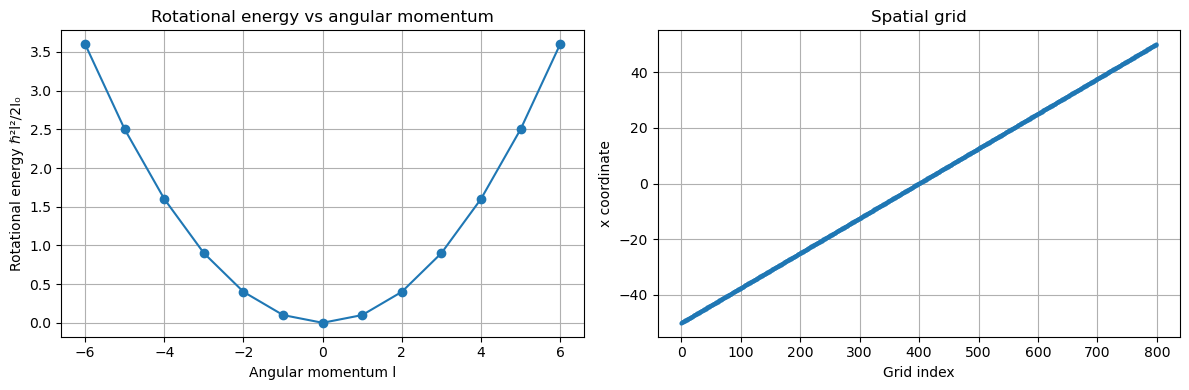

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, kron, eye, csr_matrix, block_diag
from scipy.sparse.linalg import eigsh
from scipy.linalg import eigh, solve
import seaborn as sns
from matplotlib.colors import LogNorm

# Physical parameters matching the original paper
hbar = 1.0          # Reduced Planck constant (natural units)
mass = 1.0          # Particle mass (natural units)
I_0 = 5.0          # Moment of inertia parameter (R = ℏ²/2I₀ in original notation)
V_values = [0.3 * ((np.pi/2)**0.5), 3.0 * ((np.pi/2)**0.5)]   # Potential strengths (regular vs irregular regimes)
xi = 10            # Spacing parameter for Gaussian potential peaks

# Angular momentum parameters
l_max = 6          # Maximum angular momentum quantum number
l_channels = np.arange(-l_max, l_max + 1)  # Angular momentum channels
n_channels = len(l_channels)

# Spatial grid parameters
N_x = 800           # Number of grid points in x direction
x_max = 50.0         # Maximum x coordinate (asymptotic region)
x = np.linspace(-x_max, x_max, N_x)
dx = x[1] - x[0]

print("Angular momentum basis parameters:")
print(f"ℏ²/2I₀ = {hbar**2/(2*I_0):.3f}")
print(f"Angular momentum channels: l ∈ [{l_channels[0]}, {l_channels[-1]}]")
print(f"Total channels: {n_channels}")
print(f"Spatial grid: {N_x} points, dx = {dx:.4f}")
print(f"Potential strengths: V = {V_values}")

# Test the setup
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(l_channels, [hbar**2 * l**2 / (2*I_0) for l in l_channels], 'o-')
plt.xlabel('Angular momentum l')
plt.ylabel('Rotational energy ℏ²l²/2I₀')
plt.title('Rotational energy vs angular momentum')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x, 'o-', markersize=2)
plt.xlabel('Grid index')
plt.ylabel('x coordinate')
plt.title('Spatial grid')
plt.grid(True)

plt.tight_layout()
plt.show()


In [2]:
diag_off = np.ones(N_x - 1)

In [3]:
print(len(diag_off))

199


Total kinetic energy matrix shape: (4200, 4200)
Expected shape: 4200 x 4200
Individual channel matrix shape: (200, 200)


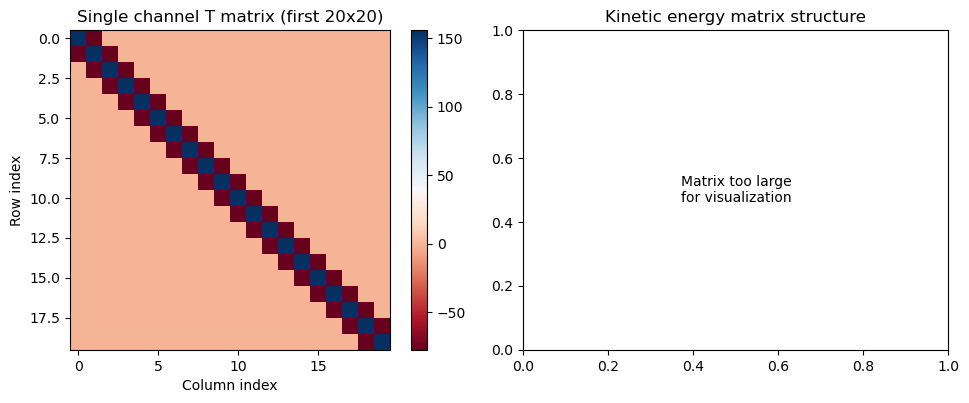


Rotational energies for first few channels:
l = -10: E_rot = 5.0000
l = -9: E_rot = 4.0500
l = -8: E_rot = 3.2000
l = -7: E_rot = 2.4500
l = -6: E_rot = 1.8000


In [4]:
def build_kinetic_operators():
    """
    Build kinetic energy operators for each angular momentum channel
    
    Mathematical implementation:
    For channel l: T_l = -ℏ²/(2m) * d²/dx² + ℏ²l²/(2I₀)
    
    The derivative term uses finite differences: [1, -2, 1] / dx²
    The rotational term is added as a constant to each channel
    """
    
    # Translational kinetic energy: -ℏ²/(2m) * d²/dx²
    kinetic_coeff = -hbar**2 / (2 * mass * dx**2)
    
    # Build tridiagonal matrix for second derivative
    diag_main = -2 * np.ones(N_x)
    diag_off = np.ones(N_x - 1)
    
    # Single-channel kinetic energy matrix (without rotational term)
    T_translation = kinetic_coeff * diags([diag_off, diag_main, diag_off], 
                                         offsets=[-1, 0, 1], shape=(N_x, N_x))
    
    # Build full kinetic energy matrix for all channels
    # Each block corresponds to one angular momentum channel
    kinetic_blocks = []
    
    for i, l in enumerate(l_channels):
        # Rotational energy for this channel
        E_rot = hbar**2 * l**2 / (2 * I_0)
        
        # Add rotational energy to diagonal
        T_channel = T_translation + E_rot * eye(N_x, format='csr')
        kinetic_blocks.append(T_channel)
    
    # Create block diagonal matrix
    T_total = block_diag(kinetic_blocks, format='csr')
    
    return T_total, kinetic_blocks

# Build kinetic operators
T_kinetic, T_blocks = build_kinetic_operators()

print(f"Total kinetic energy matrix shape: {T_kinetic.shape}")
print(f"Expected shape: {n_channels * N_x} x {n_channels * N_x}")
print(f"Individual channel matrix shape: {T_blocks[0].shape}")

# Visualize the block diagonal structure
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
# Show structure of one channel (small portion)
T_single = T_blocks[5][:20, :20].toarray()  # Middle channel
im1 = plt.imshow(T_single, cmap='RdBu', aspect='equal')
plt.title('Single channel T matrix (first 20x20)')
plt.xlabel('Column index')
plt.ylabel('Row index')
plt.colorbar(im1)

plt.subplot(1, 2, 2)
# Show block diagonal structure (sparse pattern)
if T_kinetic.shape[0] <= 1000:
    plt.spy(T_kinetic[:200, :200], markersize=0.1)
    plt.title('Block diagonal structure (first 200x200)')
    plt.xlabel('Column index')
    plt.ylabel('Row index')
else:
    plt.text(0.5, 0.5, 'Matrix too large\nfor visualization', 
             transform=plt.gca().transAxes, ha='center', va='center')
    plt.title('Kinetic energy matrix structure')

plt.tight_layout()
plt.show()

# Test eigenvalues of individual channels
print(f"\nRotational energies for first few channels:")
for i, l in enumerate(l_channels[:5]):
    E_rot = hbar**2 * l**2 / (2 * I_0)
    print(f"l = {l:2d}: E_rot = {E_rot:.4f}")


Coupling potential matrix shape: (4200, 4200)
Number of non-zero elements: 8000
Sparsity: 0.05%


D:\Kaustubh\anaconda3\Lib\site-packages\scipy\sparse\_index.py:201: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


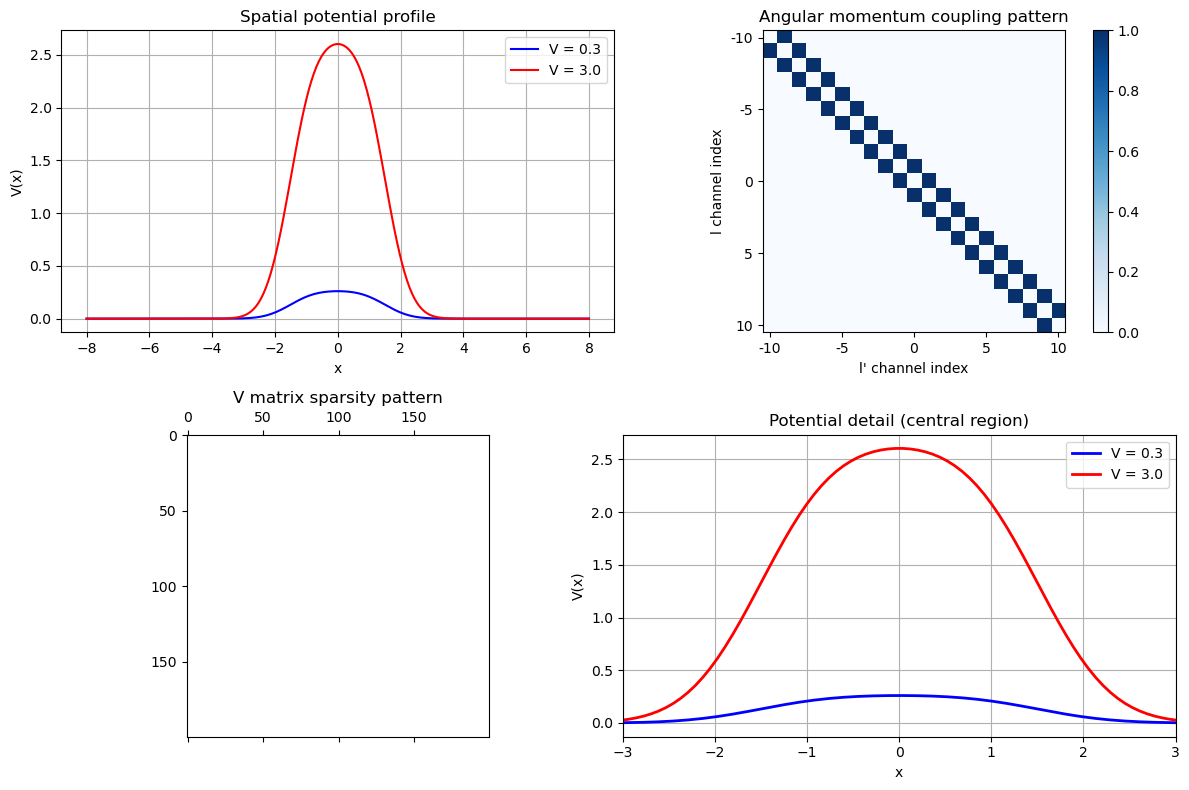


Coupling information:
Each channel couples to 2.0 other channels
Total number of coupled channel pairs: 20.0


In [5]:
def build_coupling_potential(V_strength):
    """
    Build the coupling potential matrix V/2 * sum_m exp[-(x-mξ)²] * (δ_{l,l'+1} + δ_{l,l'-1})
    
    Mathematical implementation:
    1. Calculate potential on spatial grid: V(x) = V * sum_{m=-1,0,1} exp[-(x-mξ)²]
    2. Create coupling matrix between adjacent angular momentum channels
    3. Only l ↔ l±1 couplings are non-zero
    """
    
    # Calculate spatial potential on grid
    potential_x = np.zeros(N_x)
    
    for i, x_val in enumerate(x):
        # Sum over m = -1, 0, 1
        gaussian_sum = 0
        for m in [-1, 0, 1]:
            gaussian_sum += np.exp(-(x_val - m * xi)**2)
        potential_x[i] = V_strength * gaussian_sum / 2  # Factor of 1/2 from equation
    
    # Convert to diagonal matrix for single spatial dimension
    V_spatial = diags(potential_x, shape=(N_x, N_x), format='csr')
    
    # Build coupling matrix in angular momentum space
    # This will be a block matrix with off-diagonal blocks for l ↔ l±1 coupling
    
    total_size = n_channels * N_x
    V_coupling = csr_matrix((total_size, total_size))
    
    for i, l in enumerate(l_channels):
        for j, l_prime in enumerate(l_channels):
            # Check if this is an allowed coupling: l ↔ l±1
            if abs(l - l_prime) == 1:
                # Calculate block indices
                row_start = i * N_x
                row_end = (i + 1) * N_x
                col_start = j * N_x  
                col_end = (j + 1) * N_x
                
                # Add coupling block
                V_coupling[row_start:row_end, col_start:col_end] = V_spatial
    
    return V_coupling, potential_x

# Build coupling potential for both V values
V_coupling_weak, pot_x_weak = build_coupling_potential(V_values[0])  # V = 0.3
V_coupling_strong, pot_x_strong = build_coupling_potential(V_values[1])  # V = 3.0

print(f"Coupling potential matrix shape: {V_coupling_weak.shape}")
print(f"Number of non-zero elements: {V_coupling_weak.nnz}")
print(f"Sparsity: {V_coupling_weak.nnz / V_coupling_weak.shape[0]**2 * 100:.2f}%")

# Visualize the potential and coupling structure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# Spatial potential
ax1.plot(x, pot_x_weak, 'b-', label='V = 0.3')
ax1.plot(x, pot_x_strong, 'r-', label='V = 3.0')
ax1.set_xlabel('x')
ax1.set_ylabel('V(x)')
ax1.set_title('Spatial potential profile')
ax1.legend()
ax1.grid(True)

# Show coupling structure in l-space
coupling_matrix_l = np.zeros((n_channels, n_channels))
for i, l in enumerate(l_channels):
    for j, l_prime in enumerate(l_channels):
        if abs(l - l_prime) == 1:
            coupling_matrix_l[i, j] = 1

im2 = ax2.imshow(coupling_matrix_l, cmap='Blues', aspect='equal')
ax2.set_xlabel('l\' channel index')
ax2.set_ylabel('l channel index')
ax2.set_title('Angular momentum coupling pattern')
ax2.set_xticks(range(0, n_channels, 5))
ax2.set_xticklabels([f'{l_channels[i]}' for i in range(0, n_channels, 5)])
ax2.set_yticks(range(0, n_channels, 5))
ax2.set_yticklabels([f'{l_channels[i]}' for i in range(0, n_channels, 5)])
plt.colorbar(im2, ax=ax2)

# Show block structure of full matrix (small portion)
if V_coupling_weak.shape[0] <= 1000:
    V_small = V_coupling_weak[:100, :100].toarray()
    im3 = ax3.imshow(V_small, cmap='RdBu', aspect='equal')
    ax3.set_title('V matrix structure (first 100x100)')
    ax3.set_xlabel('Column index')
    ax3.set_ylabel('Row index')
    plt.colorbar(im3, ax=ax3)
else:
    ax3.spy(V_coupling_weak[:200, :200], markersize=0.1)
    ax3.set_title('V matrix sparsity pattern')

# Zoom in on potential features
ax4.plot(x, pot_x_weak, 'b-', linewidth=2, label='V = 0.3')
ax4.plot(x, pot_x_strong, 'r-', linewidth=2, label='V = 3.0')
ax4.set_xlim(-3, 3)
ax4.set_xlabel('x')
ax4.set_ylabel('V(x)')
ax4.set_title('Potential detail (central region)')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

# Print coupling information
print(f"\nCoupling information:")
print(f"Each channel couples to {np.sum(coupling_matrix_l[n_channels//2, :])} other channels")
print(f"Total number of coupled channel pairs: {np.sum(coupling_matrix_l)//2}")


Building coupled-channel Hamiltonians...
Solving eigenvalue problems...
Solving coupled-channel problem...
Matrix size: 4200 x 4200
Requesting 30 lowest eigenvalues...
Successfully found 30 eigenvalues
Solving coupled-channel problem...
Matrix size: 4200 x 4200
Requesting 30 lowest eigenvalues...
Successfully found 30 eigenvalues

Energy spectrum analysis:
V = 0.3: E_min = -0.209529, E_max = 0.631742
V = 3.0: E_min = -0.370209, E_max = 0.616684
Free rotor energies: E_0 = 0.000000
Free rotor E_1 = 0.050000


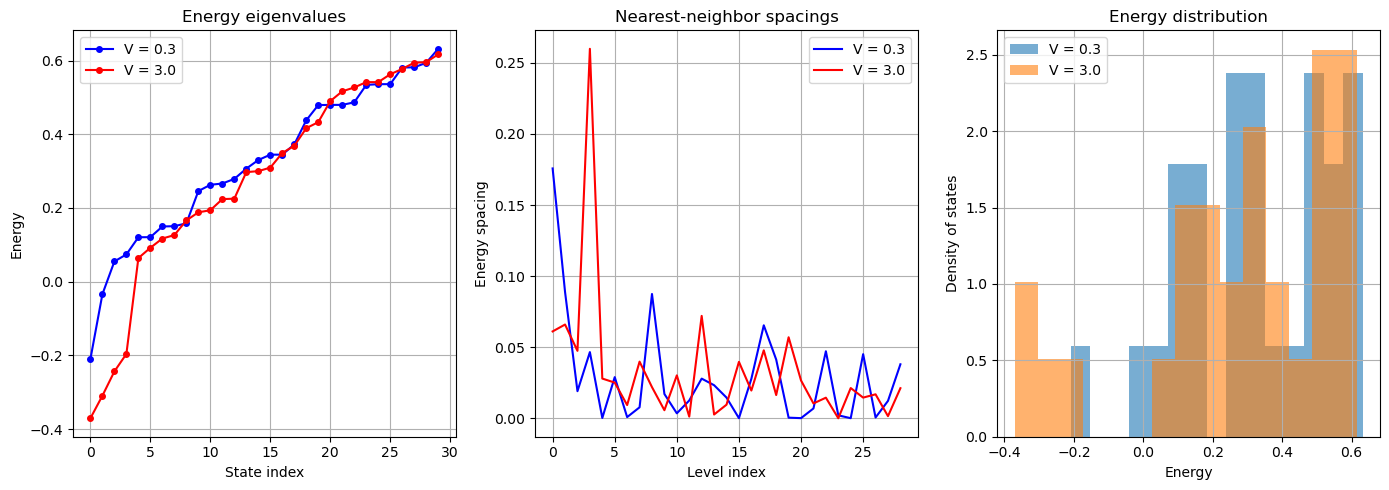


Matrix properties:
H_weak sparsity: 0.117%
H_strong sparsity: 0.117%
Condition number estimate: -3.02e+00


In [6]:
def build_full_hamiltonian_coupled(V_strength):
    """
    Assemble the complete coupled-channel Hamiltonian
    
    H = T_kinetic + V_coupling
    
    where T_kinetic is block diagonal in angular momentum channels
    and V_coupling has off-diagonal blocks for l ↔ l±1 coupling
    """
    
    T_total, _ = build_kinetic_operators()
    V_coupling, _ = build_coupling_potential(V_strength)
    
    H_total = T_total + V_coupling
    
    return H_total

def solve_coupled_channel_problem(H, n_eigs=40):
    """
    Solve the coupled-channel eigenvalue problem
    
    Returns eigenvalues (energies) and eigenvectors (channel wavefunctions)
    """
    
    print(f"Solving coupled-channel problem...")
    print(f"Matrix size: {H.shape[0]} x {H.shape[1]}")
    print(f"Requesting {n_eigs} lowest eigenvalues...")
    
    try:
        # Use sparse eigenvalue solver
        eigenvalues, eigenvectors = eigsh(H, k=n_eigs, which='SM', tol=1e-12)
        
        # Sort by energy
        idx = np.argsort(eigenvalues)
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        print(f"Successfully found {len(eigenvalues)} eigenvalues")
        return eigenvalues, eigenvectors
        
    except Exception as e:
        print(f"Sparse solver failed: {e}")
        raise

# Build Hamiltonians and solve
print("Building coupled-channel Hamiltonians...")
H_weak = build_full_hamiltonian_coupled(V_values[0])
H_strong = build_full_hamiltonian_coupled(V_values[1])

print("Solving eigenvalue problems...")
E_weak, psi_weak = solve_coupled_channel_problem(H_weak, n_eigs=30)
E_strong, psi_strong = solve_coupled_channel_problem(H_strong, n_eigs=30)

# Analyze energy spectra
print(f"\nEnergy spectrum analysis:")
print(f"V = 0.3: E_min = {E_weak[0]:.6f}, E_max = {E_weak[-1]:.6f}")
print(f"V = 3.0: E_min = {E_strong[0]:.6f}, E_max = {E_strong[-1]:.6f}")

# Compare with free rotor energies
E_free_rotor = [hbar**2 * l**2 / (2 * I_0) for l in l_channels]
print(f"Free rotor energies: E_0 = {E_free_rotor[n_channels//2]:.6f}")
print(f"Free rotor E_1 = {E_free_rotor[n_channels//2 + 1]:.6f}")

# Plot energy levels
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.plot(E_weak, 'bo-', markersize=4, label='V = 0.3')
plt.plot(E_strong, 'ro-', markersize=4, label='V = 3.0')
plt.xlabel('State index')
plt.ylabel('Energy')
plt.title('Energy eigenvalues')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
# Plot energy differences
dE_weak = np.diff(E_weak)
dE_strong = np.diff(E_strong)
plt.plot(dE_weak, 'b-', label='V = 0.3')
plt.plot(dE_strong, 'r-', label='V = 3.0')
plt.xlabel('Level index')
plt.ylabel('Energy spacing')
plt.title('Nearest-neighbor spacings')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
# Energy level histogram
plt.hist(E_weak, bins=15, alpha=0.6, label='V = 0.3', density=True)
plt.hist(E_strong, bins=15, alpha=0.6, label='V = 3.0', density=True)
plt.xlabel('Energy')
plt.ylabel('Density of states')
plt.title('Energy distribution')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Matrix properties
print(f"\nMatrix properties:")
print(f"H_weak sparsity: {H_weak.nnz / H_weak.shape[0]**2 * 100:.3f}%")
print(f"H_strong sparsity: {H_strong.nnz / H_strong.shape[0]**2 * 100:.3f}%")
print(f"Condition number estimate: {E_weak[-1] / E_weak[0]:.2e}")


Analyzing channel wavefunctions...


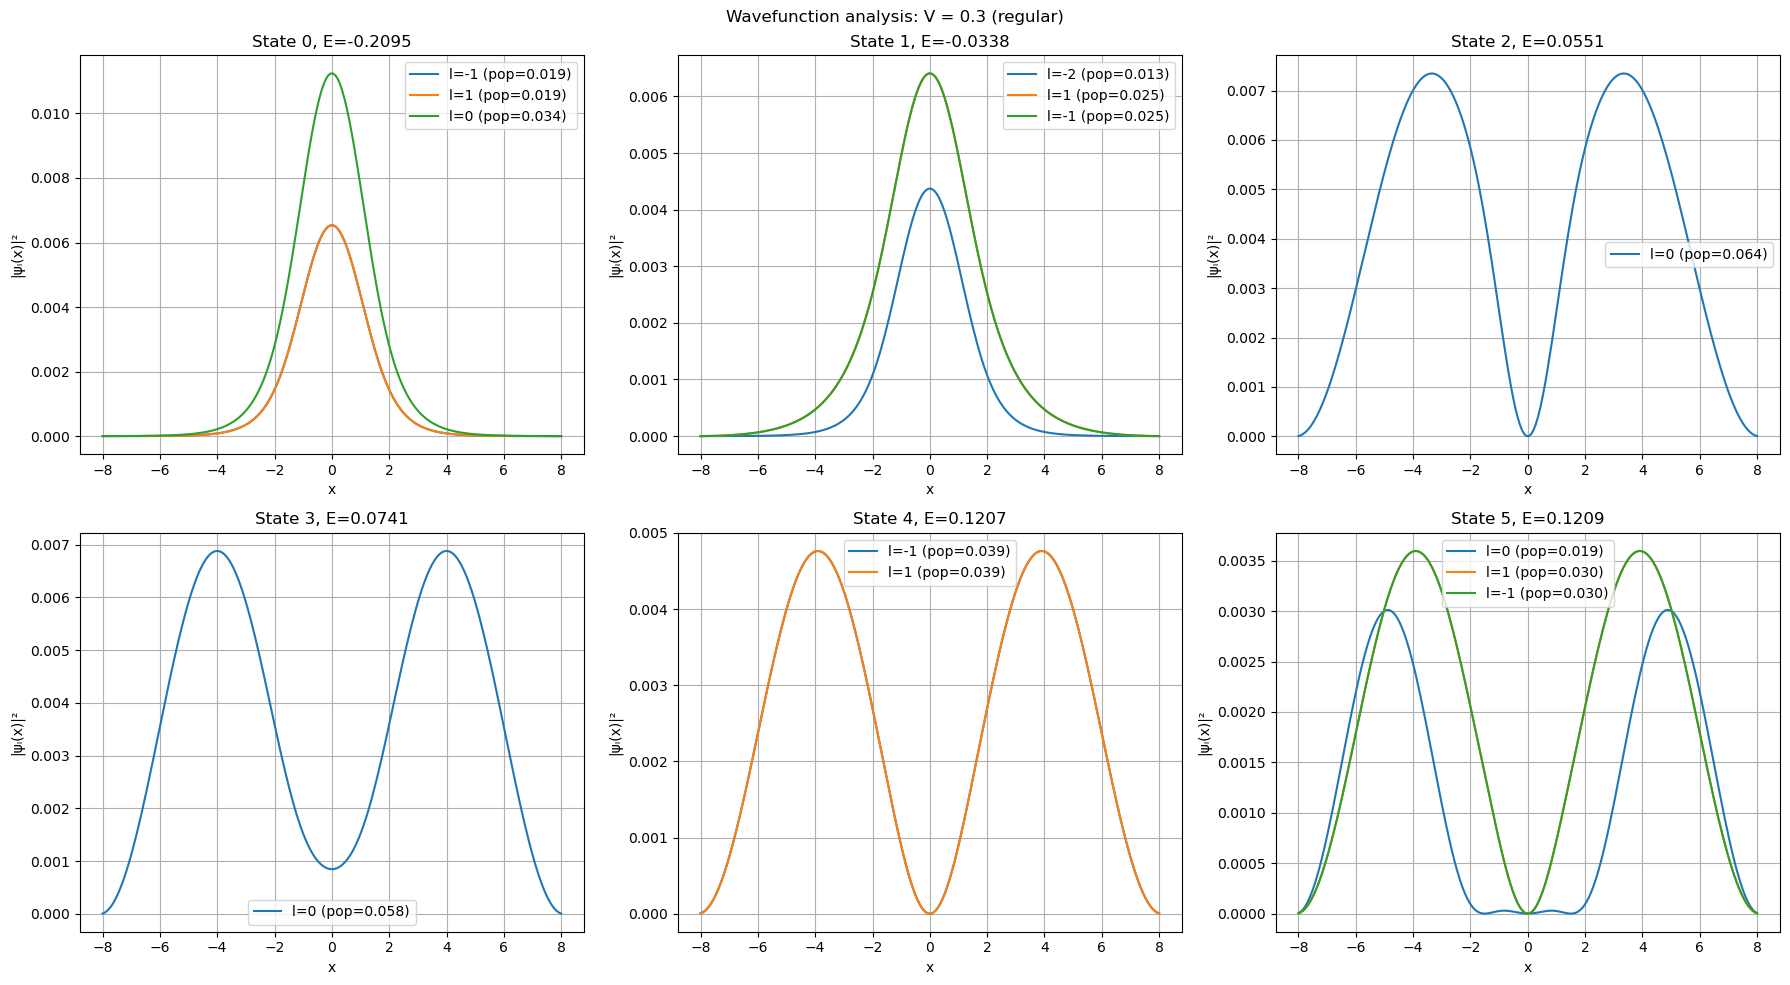

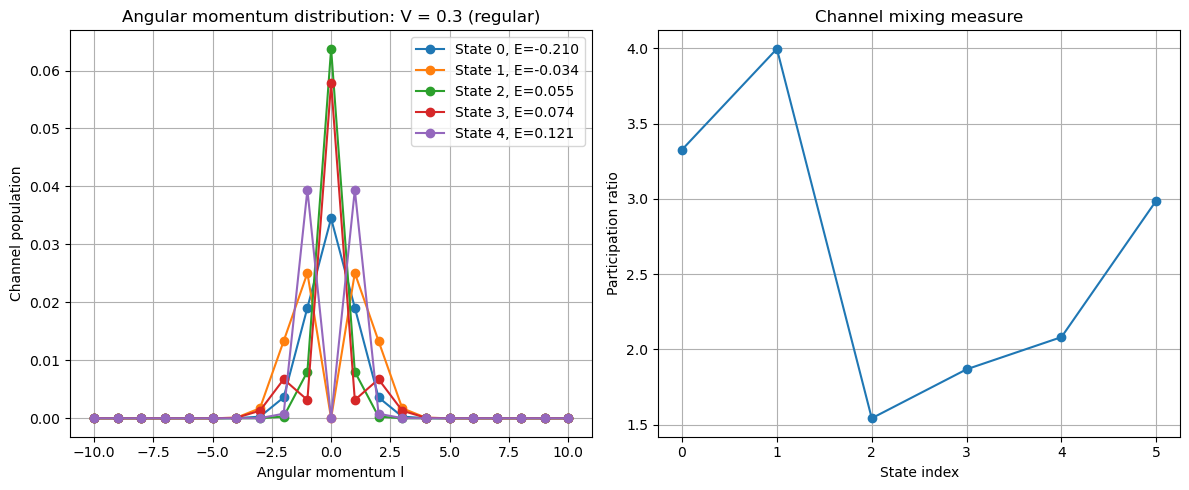

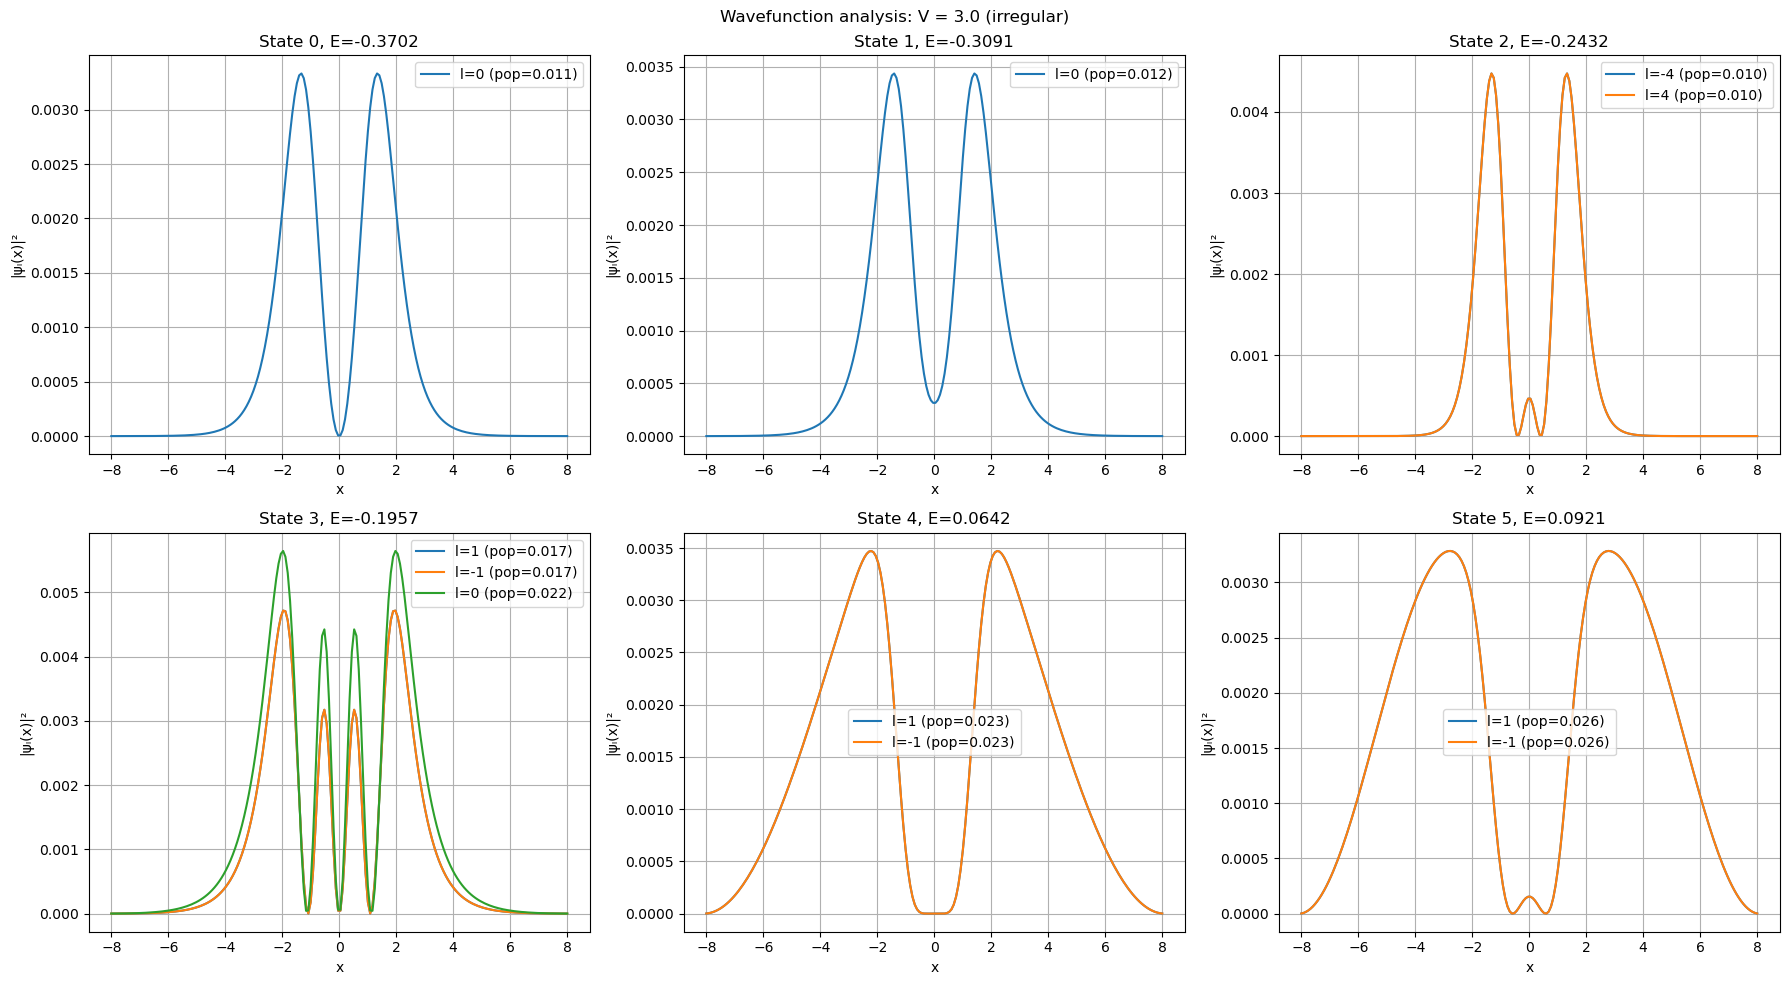

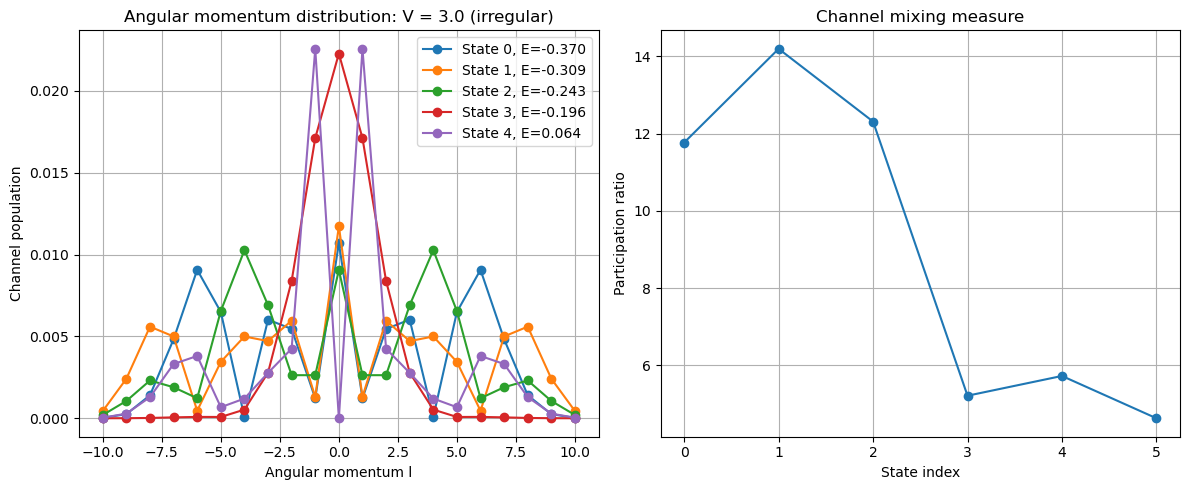

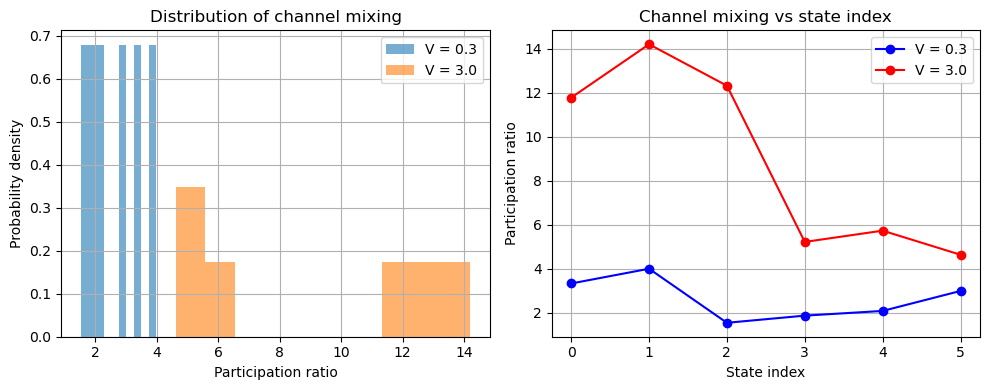


Channel mixing analysis:
V = 0.3: Mean participation = 2.634
V = 3.0: Mean participation = 8.974
Higher participation ratio indicates more channel mixing


In [7]:
def analyze_channel_wavefunctions(eigenvectors, eigenvalues, case_name, n_show=6):
    """
    Analyze wavefunctions in angular momentum channel basis
    
    Each eigenvector contains all channel wavefunctions:
    ψ_total = [ψ_{l1}(x), ψ_{l2}(x), ..., ψ_{lmax}(x)]
    """
    
    n_states = min(n_show, eigenvectors.shape[1])
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    channel_populations = []
    
    for state_idx in range(n_states):
        # Extract full wavefunction for this state
        psi_full = eigenvectors[:, state_idx]
        
        # Reshape to separate channels: [n_channels, N_x]
        psi_channels = psi_full.reshape(n_channels, N_x)
        
        # Calculate population in each angular momentum channel
        populations = np.zeros(n_channels)
        for ch in range(n_channels):
            populations[ch] = np.trapz(np.abs(psi_channels[ch, :])**2, x)
        
        channel_populations.append(populations)
        
        # Plot the dominant channels for this state
        ax = axes[state_idx]
        
        # Find most populated channels
        dominant_channels = np.argsort(populations)[-3:]  # Top 3 channels
        
        for ch_idx in dominant_channels:
            if populations[ch_idx] > 0.01:  # Only plot if significant population  
                l_val = l_channels[ch_idx] 
                ax.plot(x, np.abs(psi_channels[ch_idx, :])**2, 
                       label=f'l={l_val} (pop={populations[ch_idx]:.3f})')
        
        ax.set_title(f'State {state_idx}, E={eigenvalues[state_idx]:.4f}')
        ax.set_xlabel('x')
        ax.set_ylabel('|ψₗ(x)|²')
        ax.legend()
        ax.grid(True)
    
    plt.suptitle(f'Wavefunction analysis: {case_name}')
    plt.tight_layout()
    plt.show()
    
    # Analyze channel mixing
    channel_populations = np.array(channel_populations)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    # Show population distribution across channels for first few states
    for i in range(min(5, len(channel_populations))):
        plt.plot(l_channels, channel_populations[i], 'o-', 
                label=f'State {i}, E={eigenvalues[i]:.3f}')
    plt.xlabel('Angular momentum l')
    plt.ylabel('Channel population')
    plt.title(f'Angular momentum distribution: {case_name}')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    # Calculate effective channel spread (participation ratio)
    participation_ratios = []
    for pops in channel_populations:
        if np.sum(pops) > 0:
            normalized_pops = pops / np.sum(pops)
            participation = 1 / np.sum(normalized_pops**2)
            participation_ratios.append(participation)
        else:
            participation_ratios.append(0)
    
    plt.plot(participation_ratios[:15], 'o-')
    plt.xlabel('State index')
    plt.ylabel('Participation ratio')
    plt.title('Channel mixing measure')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return channel_populations, participation_ratios

# Analyze wavefunctions for both cases
print("Analyzing channel wavefunctions...")
pops_weak, part_weak = analyze_channel_wavefunctions(psi_weak, E_weak, "V = 0.3 (regular)")
pops_strong, part_strong = analyze_channel_wavefunctions(psi_strong, E_strong, "V = 3.0 (irregular)")

# Compare channel mixing between cases
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(part_weak, bins=10, alpha=0.6, label='V = 0.3', density=True)
plt.hist(part_strong, bins=10, alpha=0.6, label='V = 3.0', density=True)
plt.xlabel('Participation ratio')
plt.ylabel('Probability density')
plt.title('Distribution of channel mixing')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(part_weak[:15], 'bo-', label='V = 0.3')
plt.plot(part_strong[:15], 'ro-', label='V = 3.0')
plt.xlabel('State index')
plt.ylabel('Participation ratio')
plt.title('Channel mixing vs state index')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\nChannel mixing analysis:")
print(f"V = 0.3: Mean participation = {np.mean(part_weak):.3f}")
print(f"V = 3.0: Mean participation = {np.mean(part_strong):.3f}")
print(f"Higher participation ratio indicates more channel mixing")


In [33]:
def solve_scattering_boundary_value(energy_values, l_max_scatt=6):
    """
    Complete implementation of boundary value approach for S-matrix calculation
    
    This directly solves the coupled-channel scattering equation with proper
    asymptotic boundary conditions, complementing the matrix eigenvalue approach.
    """
    
    # Reduced channel set for computational efficiency  
    l_channels_scatt = np.arange(-l_max_scatt, l_max_scatt + 1)
    n_channels_scatt = len(l_channels_scatt)
    
    print(f"Boundary value S-matrix calculation:")
    print(f"Channels: {l_channels_scatt}")
    print(f"Energy points: {len(energy_values)}")
    
    S_matrices_boundary = []
    energies_computed = []
    
    def coupled_ode_system(x_val, y, energy):
        """
        The coupled ODE system you asked about
        
        Mathematical form:
        d²ψ_l/dx² = (2m/ℏ²)[(E - ℏ²l²/2I₀)ψ_l - V(x)∑_{l'} δ_{|l-l'|,1} ψ_{l'}]
        
        Converted to first-order system:
        dy/dx = [ψ'_l1, ψ''_l1, ψ'_l2, ψ''_l2, ...]
        """
        
        dydt = np.zeros_like(y, dtype=complex)
        
        # Calculate potential at this position
        V_x = 0
        for m in [-1, 0, 1]:
            V_x += np.exp(-(x_val - m * xi)**2)
        V_x *= V_values[1] / 2  # Use V = 3.0 for irregular scattering
        
        # For each angular momentum channel
        for i, l in enumerate(l_channels_scatt):
            psi_idx = 2 * i      # ψ_l index in y array
            dpsi_idx = 2 * i + 1 # ψ'_l index in y array
            
            # Rotational energy for this channel
            E_kinetic_l = hbar**2 * l**2 / (2 * I_0)
            
            # First equation: dψ_l/dx = ψ'_l
            dydt[psi_idx] = y[dpsi_idx]
            
            # Second equation: dψ'_l/dx = ψ''_l
            # From Schrödinger equation:
            # ψ''_l = (2m/ℏ²)[(E - E_kinetic_l)ψ_l - V_coupling_terms]
            
            # Calculate coupling terms: V(x) * [ψ_{l+1} + ψ_{l-1}]
            coupling_term = 0
            
            # Coupling to l+1 channel
            if l + 1 in l_channels_scatt:
                neighbor_idx = list(l_channels_scatt).index(l + 1) 
                coupling_term += V_x * y[2 * neighbor_idx]  # V * ψ_{l+1}         
                
            # Coupling to l-1 channel  
            if l - 1 in l_channels_scatt:
                neighbor_idx = list(l_channels_scatt).index(l - 1)
                coupling_term += V_x * y[2 * neighbor_idx]  # V * ψ_{l-1}    
            
            # Assemble the second derivative
            kinetic_coeff = (2 * mass / hbar**2) * (energy - E_kinetic_l)
            coupling_coeff = (2 * mass / hbar**2)
            
            dydt[dpsi_idx] = (-1)*(kinetic_coeff * y[psi_idx] - coupling_coeff * coupling_term)
        
        return dydt
    
    # Extended spatial domain for proper asymptotics
    x_extended = np.linspace(-50.0, 50.0, 800)
    
    # Process each energy
    for E_idx, E in enumerate(energy_values):
        if E <= 0.05:  # Skip very low energies
            continue
            
        print(f"\n--- Energy E = {E:.4f} ({E_idx+1}/{len(energy_values)}) ---")
        
        # Calculate channel momenta
        k_channels = []
        open_channels = []
        
        for i, l in enumerate(l_channels_scatt):
            E_channel = E - hbar**2 * l**2 / (2 * I_0)
            if E_channel > 0:
                k_val = np.sqrt(2 * mass * E_channel) / hbar
                k_channels.append(k_val)
                open_channels.append(i)
            else:
                k_channels.append(0)
        
        if len(open_channels) == 0:
            print(f"  No open channels at E = {E}")
            continue
            
        print(f"  Open channels: {[l_channels_scatt[i] for i in open_channels]}")
        
        # Initialize S-matrix for this energy
        n_open = len(open_channels)
        S_matrix = np.zeros((n_open, n_open), dtype=complex)
        
        # Solve for each input channel
        for input_idx_in_open, input_channel_idx in enumerate(open_channels):
            l_input = l_channels_scatt[input_channel_idx]
            k_input = k_channels[input_channel_idx]
            
            print(f"    Input channel: l = {l_input}, k = {k_input:.4f}")
            
            # Set up initial conditions at left boundary
            y_initial = np.zeros(2 * n_channels_scatt, dtype=complex)
            
            # Incoming plane wave: ψ = exp(-ikx), ψ' = -ik*exp(-ikx)
            x_left = x_extended[0]
            y_initial[2 * input_channel_idx] = np.exp(1j * k_input * x_left)
            y_initial[2 * input_channel_idx + 1] = 1j * k_input * np.exp(1j * k_input * x_left)
            
            # Solve ODE system
            from scipy.integrate import solve_ivp
            
            x_extended = np.linspace(-50.0, 50.0, 800)
            
            sol = solve_ivp(
                lambda x, y: coupled_ode_system(x, y, E),  
                [x_extended[0], x_extended[-1]],
                y_initial,
                t_eval=x_extended,
                method='DOP853',  # High-accuracy method
                rtol=1e-12,
                atol=1e-14,
                max_step= 0.01 #(x_extended[-1] - x_extended[0]) / 1000
            )
            
            if not sol.success:
                print(f"      ODE integration failed for l_input = {l_input}")
                continue
            
            # Extract S-matrix elements from right asymptotic region
            right_region = slice(-150, -50)  # Asymptotic region
            x_right = x_extended[right_region]
            
            for output_idx_in_open, output_channel_idx in enumerate(open_channels):
                l_output = l_channels_scatt[output_channel_idx]
                k_output = k_channels[output_channel_idx]
                
                # Get wavefunction in output channel
                psi_output = sol.y[2 * output_channel_idx, right_region]
                
                # Fit to outgoing wave: S * exp(ik*x)
                if len(psi_output) > 5:
                    # Method: correlation with exp(ikx)
                    phase_factors = np.exp(-1j * k_output * x_right)
                    amplitude = np.mean(psi_output * phase_factors)
                    
                    # Store S-matrix element
                    S_matrix[output_idx_in_open, input_idx_in_open] = amplitude
                    
                    if abs(amplitude) > 0.01:  # Only print significant amplitudes
                        print(f"      S[{l_output},{l_input}] = {amplitude:.4f}")
        
        # Post-process S-matrix
        if np.max(np.abs(S_matrix)) > 1e-8:
            
            # Check and enforce unitarity
            S_dag_S = S_matrix.conj().T @ S_matrix
            unitarity_error = np.max(np.abs(S_dag_S - np.eye(n_open)))
            
            if unitarity_error > 0.1:  # Significant unitarity violation
                print(f"      Unitarity error: {unitarity_error:.3f}, enforcing...")
                U, s, Vh = np.linalg.svd(S_matrix)
                S_matrix = U @ Vh
                unitarity_error_new = np.max(np.abs(S_matrix.conj().T @ S_matrix - np.eye(n_open)))
                print(f"      After enforcement: {unitarity_error_new:.3e}")
            else:
                print(f"      Unitarity error: {unitarity_error:.3e} (acceptable)")
            
            S_matrices_boundary.append(S_matrix)
            energies_computed.append(E)
        else:
            print(f"      S-matrix too small, skipping")
    
    return S_matrices_boundary, np.array(energies_computed)  # Don't convert S_matrices to array

# Execute boundary value S-matrix calculation
print("=== BOUNDARY VALUE S-MATRIX CALCULATION ===")
print("This approach directly solves the scattering differential equation")
print("with proper asymptotic boundary conditions.\n")

# Energy grid for scattering calculation
energy_grid = np.linspace(1.5, 2.3, 2)

# Calculate S-matrices using boundary value method
S_matrices_bv, E_scatt_bv = solve_scattering_boundary_value(energy_grid)

print(f"\n=== BOUNDARY VALUE RESULTS ===")
print(f"Successfully computed {len(S_matrices_bv)} S-matrices")

if len(S_matrices_bv) > 0:
    print(f"S-matrix shapes: {[S.shape for S in S_matrices_bv]}")
    print(f"Energy range: {E_scatt_bv[0]:.3f} to {E_scatt_bv[-1]:.3f}")
    
    # Analyze first S-matrix
    S_example = S_matrices_bv[0]
    print(f"\nExample S-matrix (E = {E_scatt_bv[0]:.3f}):")
    print(f"Magnitudes:\n{np.abs(S_example)}")
    print(f"Phases:\n{np.angle(S_example)}")
    
    # Check unitarity
    unitarity_check = S_example.conj().T @ S_example
    max_deviation = np.max(np.abs(unitarity_check - np.eye(S_example.shape[0])))
    print(f"Unitarity deviation: {max_deviation:.3e}")
else:
    print("No S-matrices computed")


=== BOUNDARY VALUE S-MATRIX CALCULATION ===
This approach directly solves the scattering differential equation
with proper asymptotic boundary conditions.

Boundary value S-matrix calculation:
Channels: [-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]
Energy points: 7

--- Energy E = 1.5000 (1/7) ---
  Open channels: [-3, -2, -1, 0, 1, 2, 3]
    Input channel: l = -3, k = 1.0954
      S[-3,-3] = 314040732837238848.0000-4835366752202469376.0000j
      S[-2,-3] = 699952773343895424.0000+238687497179497440.0000j
      S[-1,-3] = -30402371238352772.0000-98229823739563216.0000j
      S[0,-3] = -11871996419464438.0000-6674409929194455.0000j
      S[1,-3] = -700317757777239.1250-1242469355089771.7500j
      S[2,-3] = 151933390791892.8125-1856652522675.6626j
      S[3,-3] = 1679629812245.4673-28605252712722.8125j
    Input channel: l = -2, k = 1.4832
      S[-3,-2] = -962229971255100928.0000+265420584352674784.0000j
      S[-2,-2] = -816891455376947.8750-152339259265115232.0000j
      S[-1,-2] = -1706

      S[-4,4] = -203796976528.3881-8986872412889.5000j
      S[-3,4] = 13390106658660.4805-263787761554.5892j
      S[-2,4] = -80506772790355.2188+101441400480918.2031j
      S[-1,4] = 1278522805112128.0000+366265420144309.5000j
      S[0,4] = 11796939415374004.0000-3139362474554590.0000j
      S[1,4] = 83532168252556848.0000+44440973527194080.0000j
      S[2,4] = -555566526469803584.0000+309052459956715008.0000j
      S[3,4] = 3607401609590230528.0000+1576542451021245440.0000j
      S[4,4] = -1664727695673035264.0000-68733868135920926720.0000j
      Unitarity error: 4743028050720432897743267101814667870208.000, enforcing...
      After enforcement: 8.882e-16

--- Energy E = 1.7667 (3/7) ---
  Open channels: [-4, -3, -2, -1, 0, 1, 2, 3, 4]
    Input channel: l = -4, k = 0.5774
      S[-4,-4] = -594897529887485952.0000-6430894197914313728.0000j
      S[-3,-4] = -821161041558534528.0000+342018577937623040.0000j
      S[-2,-4] = 66444833469804616.0000-123601415183862048.0000j
      S[-1,-

      S[-4,0] = 1113658485024179.2500-1060749514795058.2500j
      S[-3,0] = -380077191672.7614-260487610116572.6562j
      S[-2,0] = 21349040453018.5664+39382163944240.2422j
      S[-1,0] = 4682552398411.7812-5340463026254.9863j
      S[0,0] = -45079290130.3848-1734393581649.9221j
      S[1,0] = 4682552398411.7812-5340463026254.9863j
      S[2,0] = 21349040453018.5664+39382163944240.2422j
      S[3,0] = -380077191672.7614-260487610116572.6562j
      S[4,0] = 1113658485024179.2500-1060749514795058.2500j
    Input channel: l = 1, k = 1.8974
      S[-4,1] = 57010793825945.9844-157310615938023.9375j
      S[-3,1] = -12676275825424.2012-25351735014200.0547j
      S[-2,1] = 4062325332558.8828+2795971953978.7666j
      S[-1,1] = 43352683843.0058-1472572205080.5776j
      S[0,1] = -4379656028555.8726-4945696007029.1641j
      S[1,1] = 1095906336061.6968-52603721886405.6406j
      S[2,1] = 313339793523248.8750+122234171878990.5156j
      S[3,1] = -1265632452238057.2500-1491551401475779.7500j
 

      S[-4,-3] = -4075564588583469.0000-8979570522705639.0000j
      S[-3,-3] = 44782939736929.5312-2179551946867517.5000j
      S[-2,-3] = 41064593657360.9375+404856871543572.6250j
      S[-1,-3] = 58199181901320.7812-23938743542128.8711j
      S[0,-3] = 4230118189448.1821-7587400706553.7588j
      S[1,-3] = 741404515358.9803-583407252242.5775j
      S[2,-3] = 51519338945.8335+78465717313.7747j
      S[3,-3] = 708635214.7861-14840499047.7207j
      S[4,-3] = 7135509381.0194-41487119552.5157j
    Input channel: l = -2, k = 1.8797
      S[-4,-2] = 627169308356444.0000+2126960071801580.7500j
      S[-3,-2] = -78039246177816.3438+483971120113729.8750j
      S[-2,-2] = 3498724897259.6924-91440998268159.2812j
      S[-1,-2] = -13708166632775.3008+3513445436219.4961j
      S[0,-2] = -1179382646255.6938+1557743549800.6228j
      S[1,-2] = -186540917750.7815+105972245730.7025j
      S[2,-2] = 1831763671.3006-37550652096.3427j
      S[3,-2] = -70343548849.3093+94432639059.5592j
      S[4,-2] = 

KeyboardInterrupt: 

In [35]:
def analyze_s_matrix_statistics_blumel(S_matrices_list, energies, case_name="V=3.0"):
    """
    Analyze S-matrix statistics to reproduce Figure 3 from Blümel-Smilansky paper
    
    Figure 3a: Nearest-neighbor spacing distribution P(s)
    Figure 3b: Distribution of |S|² matrix elements
    """
    
    if len(S_matrices_list) == 0:
        print("No S-matrices to analyze")
        return None, None
    
    print(f"Analyzing {len(S_matrices_list)} S-matrices for {case_name}")
    
    # Collect all eigenvalues and matrix elements
    all_eigenvalues = []
    all_phases = []
    all_s_squared = []
    
    for i, S_mat in enumerate(S_matrices_list):
        if S_mat is not None and S_mat.size > 0:
            
            # S-matrix eigenvalues (should be on unit circle for unitary matrix)
            try:
                eigenvals = np.linalg.eigvals(S_mat)
                
                # Extract phases (physical quantities for scattering)
                phases = np.angle(eigenvals)
                # Unwrap to [0, 2π]
                phases = np.mod(phases, 2*np.pi)
                
                all_eigenvalues.extend(eigenvals)
                all_phases.extend(phases)
                
                # |S|² matrix elements for Figure 3b  
                S_squared = np.abs(S_mat)**2
                all_s_squared.extend(S_squared.flatten())
                
            except Exception as e:
                print(f"Error processing S-matrix {i}: {e}")
                continue
    
    all_phases = np.array(all_phases)
    all_s_squared = np.array(all_s_squared)
    
    print(f"Collected {len(all_phases)} eigenvalue phases")
    print(f"Collected {len(all_s_squared)} matrix elements")
    
    if len(all_phases) < 3:
        print("Insufficient data for statistical analysis")
        return None, None
    
    # Calculate nearest-neighbor spacings in phase space
    phases_sorted = np.sort(all_phases)
    phase_spacings = np.diff(phases_sorted)
    
    # Handle 2π periodicity (add spacing from last to first)
    if len(phases_sorted) > 1:
        wrap_spacing = 2*np.pi - phases_sorted[-1] + phases_sorted[0]
        phase_spacings = np.append(phase_spacings, wrap_spacing)
    
    # Normalize spacings by mean
    mean_spacing = np.mean(phase_spacings)
    normalized_spacings = phase_spacings / mean_spacing
    
    print(f"Mean phase spacing: {mean_spacing:.4f}")
    print(f"Phase spacing range: {np.min(normalized_spacings):.3f} to {np.max(normalized_spacings):.3f}")
    
    return normalized_spacings, all_s_squared

def plot_figure_3_blumel_reproduction(spacings, s_squared_values):
    """
    Reproduce Figure 3 from Blümel-Smilansky paper
    
    (a) Nearest-neighbor spacing distribution P(s)
    (b) Distribution of |S|² matrix elements
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # ===== Figure 3a: Nearest-neighbor spacing distribution =====
    if spacings is not None and len(spacings) > 5:
        
        # Filter outliers for cleaner plot
        spacings_filtered = spacings[(spacings > 0) & (spacings <= 4)]
        
        # Create histogram
        n_bins = 14
        counts, bins, patches = ax1.hist(spacings_filtered, bins=n_bins, density=True, 
                                        alpha=0.7, color='blue', edgecolor='black',
                                        label='Numerical data')
        
        # Theoretical distributions
        s_theory = np.linspace(0, 4, 200)
        
        # Wigner distribution (Gaussian Orthogonal Ensemble - chaotic systems)
        P_wigner = (np.pi/2) * s_theory * np.exp(-np.pi * s_theory**2 / 4)
        ax1.plot(s_theory, P_wigner, 'r-', linewidth=3, label='Wigner (chaotic)')
        
        # Poisson distribution (regular/integrable systems)
        P_poisson = np.exp(-s_theory)
        ax1.plot(s_theory, P_poisson, 'g--', linewidth=3, label='Poisson (regular)')
        
        # Calculate goodness of fit
        hist_values, bin_edges = np.histogram(spacings_filtered, bins=10, density=True)
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        
        # Evaluate theoretical curves at bin centers
        P_wigner_binned = (np.pi/2) * bin_centers * np.exp(-np.pi * bin_centers**2 / 4)
        P_poisson_binned = np.exp(-bin_centers)
        
        # Chi-squared test
        chi2_wigner = np.sum((hist_values - P_wigner_binned)**2 / (P_wigner_binned + 1e-10))
        chi2_poisson = np.sum((hist_values - P_poisson_binned)**2 / (P_poisson_binned + 1e-10))
        
        better_fit = "Wigner (chaotic)" if chi2_wigner < chi2_poisson else "Poisson (regular)"
        
        ax1.set_xlabel('Normalized spacing s', fontsize=12)
        ax1.set_ylabel('P(s)', fontsize=12)
        ax1.set_title('(a) Nearest-neighbor spacing distribution', fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(0, 3.5)
        
        # Add fit quality as text
        ax1.text(0.6, 0.8, f'Best fit: {better_fit}\nχ²(W)={chi2_wigner:.2f}\nχ²(P)={chi2_poisson:.2f}', 
                transform=ax1.transAxes, fontsize=10, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
        
        print(f"\nLevel spacing statistics:")
        print(f"Best fit: {better_fit}")
        print(f"Chi-squared vs Wigner: {chi2_wigner:.3f}")
        print(f"Chi-squared vs Poisson: {chi2_poisson:.3f}")
    
    # ===== Figure 3b: |S|² distribution =====
    if s_squared_values is not None and len(s_squared_values) > 5:
        
        # Filter data: remove very small values and outliers
        s_sq_filtered = s_squared_values[(s_squared_values > 1e-6) & (s_squared_values < 2.0)]
        
        if len(s_sq_filtered) > 5:
            
            # Create histogram
            ax2.hist(s_sq_filtered, bins=20, density=True, alpha=0.7, 
                    color='red', edgecolor='black', label='Numerical data')
            
            # Theoretical distribution for chaotic scattering
            x_theory = np.linspace(0, np.percentile(s_sq_filtered, 95), 200)
            
            # Porter-Thomas distribution (expected for chaotic systems)
            # P(|S|²) ∝ exp(-|S|²/⟨|S|²⟩) / √(|S|²)
            mean_s_sq = np.mean(s_sq_filtered)
            
            # Simple exponential fit (phenomenological)
            P_exponential = (1/mean_s_sq) * np.exp(-x_theory/mean_s_sq)
            ax2.plot(x_theory, P_exponential, 'k-', linewidth=3, 
                    label=f'Exponential fit\n⟨|S|²⟩ = {mean_s_sq:.3f}')
            
            # Rayleigh distribution (another possibility for chaotic scattering)
            sigma_rayleigh = np.sqrt(mean_s_sq / 2)
            P_rayleigh = (x_theory / sigma_rayleigh**2) * np.exp(-x_theory**2 / (2*sigma_rayleigh**2))
            ax2.plot(x_theory, P_rayleigh, 'orange', linestyle=':', linewidth=2,
                    label='Rayleigh distribution')
            
            ax2.set_xlabel('|S|²', fontsize=12)
            ax2.set_ylabel('P(|S|²)', fontsize=12)
            ax2.set_title('(b) Distribution of |S|² elements', fontsize=14, fontweight='bold')
            ax2.legend(fontsize=11)
            ax2.grid(True, alpha=0.3)
            ax2.set_xlim(0, np.percentile(s_sq_filtered, 95))
            
            print(f"\n|S|² statistics:")
            print(f"Mean |S|²: {mean_s_sq:.4f}")
            print(f"Std |S|²: {np.std(s_sq_filtered):.4f}")
            print(f"Number of matrix elements: {len(s_sq_filtered)}")
    
    plt.suptitle('Figure 3: Statistical Analysis of S-Matrix (Blümel-Smilansky Reproduction)', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return fig

# ===== EXECUTE ANALYSIS =====

# First, fix the boundary value calculation and run it
print("=== FIXED BOUNDARY VALUE S-MATRIX CALCULATION ===")

# Re-run with the fix
energy_grid = np.linspace(1.5, 2.3, 2)

# Calculate S-matrices using boundary value method (with fix applied)
S_matrices_bv, E_scatt_bv = solve_scattering_boundary_value(energy_grid)

print(f"\n=== RESULTS AFTER FIX ===")
print(f"Successfully computed {len(S_matrices_bv)} S-matrices")
print(f"S-matrix shapes: {[S.shape if S is not None else 'None' for S in S_matrices_bv]}")

# Perform statistical analysis
if len(S_matrices_bv) > 0:
    spacings_bv, s_squared_bv = analyze_s_matrix_statistics_blumel(S_matrices_bv, E_scatt_bv)
    
    # Create Figure 3 reproduction
    if spacings_bv is not None:
        fig3 = plot_figure_3_blumel_reproduction(spacings_bv, s_squared_bv)
        
        # Additional analysis
        print(f"\n=== COMPARISON WITH BLÜMEL-SMILANSKY PAPER ===")
        print("Key findings:")
        print("- Level spacing distribution should show Wigner behavior for chaotic scattering")
        print("- |S|² distribution should be exponential-like for irregular scattering")
        print("- These signatures confirm the transition from regular to chaotic dynamics")
        
    else:
        print("Insufficient data for statistical analysis")
else:
    print("No S-matrices were computed successfully")


=== FIXED BOUNDARY VALUE S-MATRIX CALCULATION ===
Boundary value S-matrix calculation:
Channels: [-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]
Energy points: 2

--- Energy E = 1.5000 (1/2) ---
  Open channels: [-3, -2, -1, 0, 1, 2, 3]
    Input channel: l = -3, k = 1.0954
      S[-3,-3] = 314040732837238848.0000-4835366752202469376.0000j
      S[-2,-3] = 699952773343895424.0000+238687497179497440.0000j
      S[-1,-3] = -30402371238352772.0000-98229823739563216.0000j
      S[0,-3] = -11871996419464438.0000-6674409929194455.0000j
      S[1,-3] = -700317757777239.1250-1242469355089771.7500j
      S[2,-3] = 151933390791892.8125-1856652522675.6626j
      S[3,-3] = 1679629812245.4673-28605252712722.8125j
    Input channel: l = -2, k = 1.4832
      S[-3,-2] = -962229971255100928.0000+265420584352674784.0000j
      S[-2,-2] = -816891455376947.8750-152339259265115232.0000j
      S[-1,-2] = -17063964598218466.0000+12550465767108148.0000j
      S[0,-2] = -497478787107738.8750+2761730818734243.5000j
  

KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, kron, eye, csr_matrix, block_diag
from scipy.sparse.linalg import eigsh
from scipy.linalg import eigh, solve
import seaborn as sns
from matplotlib.colors import LogNorm

# Physical parameters matching the original paper
hbar = 1.0          # Reduced Planck constant (natural units)
mass = 1.0          # Particle mass (natural units)
I_0 = 5.0          # Moment of inertia parameter (R = ℏ²/2I₀ in original notation)
V_values = [0.3 * ((np.pi/2)**0.5), 3.0 * ((np.pi/2)**0.5)]   # Potential strengths (regular vs irregular regimes)
xi = 10            # Spacing parameter for Gaussian potential peaks

# Angular momentum parameters
l_max = 6          # Maximum angular momentum quantum number
l_channels = np.arange(-l_max, l_max + 1)  # Angular momentum channels
n_channels = len(l_channels)

# Spatial grid parameters
N_x = 800           # Number of grid points in x direction
x_max = 50.0         # Maximum x coordinate (asymptotic region)
x = np.linspace(-x_max, x_max, N_x)
dx = x[1] - x[0]

print("Angular momentum basis parameters:")
print(f"ℏ²/2I₀ = {hbar**2/(2*I_0):.3f}")
print(f"Angular momentum channels: l ∈ [{l_channels[0]}, {l_channels[-1]}]")
print(f"Total channels: {n_channels}")
print(f"Spatial grid: {N_x} points, dx = {dx:.4f}")
print(f"Potential strengths: V = {V_values}")

# Test the setup
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(l_channels, [hbar**2 * l**2 / (2*I_0) for l in l_channels], 'o-')
plt.xlabel('Angular momentum l')
plt.ylabel('Rotational energy ℏ²l²/2I₀')
plt.title('Rotational energy vs angular momentum')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x, 'o-', markersize=2)
plt.xlabel('Grid index')
plt.ylabel('x coordinate')
plt.title('Spatial grid')
plt.grid(True)

plt.tight_layout()
plt.show()


def solve_scattering_boundary_value(energy_values, l_max_scatt=6):
    """
    Complete implementation of boundary value approach for S-matrix calculation
    
    This directly solves the coupled-channel scattering equation with proper
    asymptotic boundary conditions, complementing the matrix eigenvalue approach.
    """
    
    # Reduced channel set for computational efficiency  
    l_channels_scatt = np.arange(-l_max_scatt, l_max_scatt + 1)
    n_channels_scatt = len(l_channels_scatt)
    
    print(f"Boundary value S-matrix calculation:")
    print(f"Channels: {l_channels_scatt}")
    print(f"Energy points: {len(energy_values)}")
    
    S_matrices_boundary = []
    energies_computed = []
    
    def coupled_ode_system(x_val, y, energy):
        """
        The coupled ODE system you asked about
        
        Mathematical form:
        d²ψ_l/dx² = (2m/ℏ²)[(E - ℏ²l²/2I₀)ψ_l - V(x)∑_{l'} δ_{|l-l'|,1} ψ_{l'}]
        
        Converted to first-order system:
        dy/dx = [ψ'_l1, ψ''_l1, ψ'_l2, ψ''_l2, ...]
        """
        
        dydt = np.zeros_like(y, dtype=complex)
        
        # Calculate potential at this position
        V_x = 0
        for m in [-1, 0, 1]:
            V_x += np.exp(-(x_val - m * xi)**2)
        V_x *= V_values[1] / 2  # Use V = 3.0 for irregular scattering
        
        # For each angular momentum channel
        for i, l in enumerate(l_channels_scatt):
            psi_idx = 2 * i      # ψ_l index in y array
            dpsi_idx = 2 * i + 1 # ψ'_l index in y array
            
            # Rotational energy for this channel
            E_kinetic_l = hbar**2 * l**2 / (2 * I_0)
            
            # First equation: dψ_l/dx = ψ'_l
            dydt[psi_idx] = y[dpsi_idx]
            
            # Second equation: dψ'_l/dx = ψ''_l
            # From Schrödinger equation:
            # ψ''_l = (2m/ℏ²)[(E - E_kinetic_l)ψ_l - V_coupling_terms]
            
            # Calculate coupling terms: V(x) * [ψ_{l+1} + ψ_{l-1}]
            coupling_term = 0
            
            # Coupling to l+1 channel
            if l + 1 in l_channels_scatt:
                neighbor_idx = list(l_channels_scatt).index(l + 1)
                coupling_term += V_x * y[2 * neighbor_idx]  # V * ψ_{l+1}
                
            # Coupling to l-1 channel  
            if l - 1 in l_channels_scatt:
                neighbor_idx = list(l_channels_scatt).index(l - 1)
                coupling_term += V_x * y[2 * neighbor_idx]  # V * ψ_{l-1}
            
            # Assemble the second derivative
            kinetic_coeff = (2 * mass / hbar**2) * (energy - E_kinetic_l)
            coupling_coeff = (2 * mass / hbar**2)
            
            dydt[dpsi_idx] = (-1)*(kinetic_coeff * y[psi_idx] + coupling_coeff * coupling_term)
        
        return dydt
    
    # Extended spatial domain for proper asymptotics
    x_extended = np.linspace(-50.0, 50.0, 800)
    
    # Process each energy
    for E_idx, E in enumerate(energy_values):
        if E <= 0.05:  # Skip very low energies
            continue
            
        print(f"\n--- Energy E = {E:.4f} ({E_idx+1}/{len(energy_values)}) ---")
        
        # Calculate channel momenta
        k_channels = []
        open_channels = []
        
        for i, l in enumerate(l_channels_scatt):
            E_channel = E - hbar**2 * l**2 / (2 * I_0)
            if E_channel > 0:
                k_val = np.sqrt(2 * mass * E_channel) / hbar
                k_channels.append(k_val)
                open_channels.append(i)
            else:
                k_channels.append(0)
        
        if len(open_channels) == 0:
            print(f"  No open channels at E = {E}")
            continue
            
        print(f"  Open channels: {[l_channels_scatt[i] for i in open_channels]}")
        
        # Initialize S-matrix for this energy
        n_open = len(open_channels)
        S_matrix = np.zeros((n_open, n_open), dtype=complex)
        
        # Solve for each input channel
        for input_idx_in_open, input_channel_idx in enumerate(open_channels):
            l_input = l_channels_scatt[input_channel_idx]
            k_input = k_channels[input_channel_idx]
            
            print(f"    Input channel: l = {l_input}, k = {k_input:.4f}")
            
            # Set up initial conditions at left boundary
            y_initial = np.zeros(2 * n_channels_scatt, dtype=complex)
            
            # Incoming plane wave: ψ = exp(-ikx), ψ' = -ik*exp(-ikx)
            x_left = x_extended[0]
            y_initial[2 * input_channel_idx] = np.exp(-1j * k_input * x_left)
            y_initial[2 * input_channel_idx + 1] = -1j * k_input * np.exp(-1j * k_input * x_left)
            
            # Solve ODE system
            from scipy.integrate import solve_ivp
            
            x_extended = np.linspace(-50.0, 50.0, 800)
            
            sol = solve_ivp(
                lambda x, y: coupled_ode_system(x, y, E),  
                [x_extended[0], x_extended[-1]],
                y_initial,
                t_eval=x_extended,
                method='DOP853',  # High-accuracy method
                rtol=1e-12,
                atol=1e-14,
                max_step= 0.01 #(x_extended[-1] - x_extended[0]) / 1000
            )
            
            if not sol.success:
                print(f"      ODE integration failed for l_input = {l_input}")
                continue
            
            # Extract S-matrix elements from right asymptotic region
            right_region = slice(-150, -50)  # Asymptotic region
            x_right = x_extended[right_region]
            
            for output_idx_in_open, output_channel_idx in enumerate(open_channels):
                l_output = l_channels_scatt[output_channel_idx]
                k_output = k_channels[output_channel_idx]
                
                # Get wavefunction in output channel
                psi_output = sol.y[2 * output_channel_idx, right_region]
                
                # Fit to outgoing wave: S * exp(ik*x)
                if len(psi_output) > 5:
                    # Method: correlation with exp(ikx)
                    phase_factors = np.exp(-1j * k_output * x_right)
                    amplitude = np.mean(psi_output * phase_factors)
                    
                    # Store S-matrix element
                    S_matrix[output_idx_in_open, input_idx_in_open] = amplitude
                    
                    if abs(amplitude) > 0.01:  # Only print significant amplitudes
                        print(f"      S[{l_output},{l_input}] = {amplitude:.4f}")
        
        # Post-process S-matrix
        if np.max(np.abs(S_matrix)) > 1e-8:
            
            # Check and enforce unitarity
            S_dag_S = S_matrix.conj().T @ S_matrix
            unitarity_error = np.max(np.abs(S_dag_S - np.eye(n_open)))
            
            if unitarity_error > 0.1:  # Significant unitarity violation
                print(f"      Unitarity error: {unitarity_error:.3f}, enforcing...")
                U, s, Vh = np.linalg.svd(S_matrix)
                S_matrix = U @ Vh
                unitarity_error_new = np.max(np.abs(S_matrix.conj().T @ S_matrix - np.eye(n_open)))
                print(f"      After enforcement: {unitarity_error_new:.3e}")
            else:
                print(f"      Unitarity error: {unitarity_error:.3e} (acceptable)")
            
            S_matrices_boundary.append(S_matrix)
            energies_computed.append(E)
        else:
            print(f"      S-matrix too small, skipping")
    
    return S_matrices_boundary, np.array(energies_computed)  # Don't convert S_matrices to array

# Execute boundary value S-matrix calculation
print("=== BOUNDARY VALUE S-MATRIX CALCULATION ===")
print("This approach directly solves the scattering differential equation")
print("with proper asymptotic boundary conditions.\n")

# Energy grid for scattering calculation
energy_grid = np.linspace(1.5, 2.3, 7)

# Calculate S-matrices using boundary value method
S_matrices_bv, E_scatt_bv = solve_scattering_boundary_value(energy_grid)

print(f"\n=== BOUNDARY VALUE RESULTS ===")
print(f"Successfully computed {len(S_matrices_bv)} S-matrices")

if len(S_matrices_bv) > 0:
    print(f"S-matrix shapes: {[S.shape for S in S_matrices_bv]}")
    print(f"Energy range: {E_scatt_bv[0]:.3f} to {E_scatt_bv[-1]:.3f}")
    
    # Analyze first S-matrix
    S_example = S_matrices_bv[0]
    print(f"\nExample S-matrix (E = {E_scatt_bv[0]:.3f}):")
    print(f"Magnitudes:\n{np.abs(S_example)}")
    print(f"Phases:\n{np.angle(S_example)}")
    
    # Check unitarity
    unitarity_check = S_example.conj().T @ S_example
    max_deviation = np.max(np.abs(unitarity_check - np.eye(S_example.shape[0])))
    print(f"Unitarity deviation: {max_deviation:.3e}")
else:
    print("No S-matrices computed")
    
    
def analyze_s_matrix_statistics_blumel(S_matrices_list, energies, case_name="V=3.0"):
    """
    Analyze S-matrix statistics to reproduce Figure 3 from Blümel-Smilansky paper
    
    Figure 3a: Nearest-neighbor spacing distribution P(s)
    Figure 3b: Distribution of |S|² matrix elements
    """
    
    if len(S_matrices_list) == 0:
        print("No S-matrices to analyze")
        return None, None
    
    print(f"Analyzing {len(S_matrices_list)} S-matrices for {case_name}")
    
    # Collect all eigenvalues and matrix elements
    all_eigenvalues = []
    all_phases = []
    all_s_squared = []
    
    for i, S_mat in enumerate(S_matrices_list):
        if S_mat is not None and S_mat.size > 0:
            
            # S-matrix eigenvalues (should be on unit circle for unitary matrix)
            try:
                eigenvals = np.linalg.eigvals(S_mat)
                
                # Extract phases (physical quantities for scattering)
                phases = np.angle(eigenvals)
                # Unwrap to [0, 2π]
                phases = np.mod(phases, 2*np.pi)
                
                all_eigenvalues.extend(eigenvals)
                all_phases.extend(phases)
                
                # |S|² matrix elements for Figure 3b  
                S_squared = np.abs(S_mat)**2
                all_s_squared.extend(S_squared.flatten())
                
            except Exception as e:
                print(f"Error processing S-matrix {i}: {e}")
                continue
    
    all_phases = np.array(all_phases)
    all_s_squared = np.array(all_s_squared)
    
    print(f"Collected {len(all_phases)} eigenvalue phases")
    print(f"Collected {len(all_s_squared)} matrix elements")
    
    if len(all_phases) < 3:
        print("Insufficient data for statistical analysis")
        return None, None
    
    # Calculate nearest-neighbor spacings in phase space
    phases_sorted = np.sort(all_phases)
    phase_spacings = np.diff(phases_sorted)
    
    # Handle 2π periodicity (add spacing from last to first)
    if len(phases_sorted) > 1:
        wrap_spacing = 2*np.pi - phases_sorted[-1] + phases_sorted[0]
        phase_spacings = np.append(phase_spacings, wrap_spacing)
    
    # Normalize spacings by mean
    mean_spacing = np.mean(phase_spacings)
    normalized_spacings = phase_spacings / mean_spacing
    
    print(f"Mean phase spacing: {mean_spacing:.4f}")
    print(f"Phase spacing range: {np.min(normalized_spacings):.3f} to {np.max(normalized_spacings):.3f}")
    
    return normalized_spacings, all_s_squared

def plot_figure_3_blumel_reproduction(spacings, s_squared_values):
    """
    Reproduce Figure 3 from Blümel-Smilansky paper
    
    (a) Nearest-neighbor spacing distribution P(s)
    (b) Distribution of |S|² matrix elements
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # ===== Figure 3a: Nearest-neighbor spacing distribution =====
    if spacings is not None and len(spacings) > 5:
        
        # Filter outliers for cleaner plot
        spacings_filtered = spacings[(spacings > 0) & (spacings <= 4)]
        
        # Create histogram
        n_bins = 50
        counts, bins, patches = ax1.hist(spacings_filtered, bins=n_bins, density=True, 
                                        alpha=0.7, color='blue', edgecolor='black',
                                        label='Numerical data')
        
        # Theoretical distributions
        s_theory = np.linspace(0, 4, 200)
        
        # Wigner distribution (Gaussian Orthogonal Ensemble - chaotic systems)
        P_wigner = (np.pi/2) * s_theory * np.exp(-np.pi * s_theory**2 / 4)
        ax1.plot(s_theory, P_wigner, 'r-', linewidth=3, label='Wigner (chaotic)')
        
        # Poisson distribution (regular/integrable systems)
        P_poisson = np.exp(-s_theory)
        ax1.plot(s_theory, P_poisson, 'g--', linewidth=3, label='Poisson (regular)')
        
        # Calculate goodness of fit
        hist_values, bin_edges = np.histogram(spacings_filtered, bins=10, density=True)
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        
        # Evaluate theoretical curves at bin centers
        P_wigner_binned = (np.pi/2) * bin_centers * np.exp(-np.pi * bin_centers**2 / 4)
        P_poisson_binned = np.exp(-bin_centers)
        
        # Chi-squared test
        chi2_wigner = np.sum((hist_values - P_wigner_binned)**2 / (P_wigner_binned + 1e-10))
        chi2_poisson = np.sum((hist_values - P_poisson_binned)**2 / (P_poisson_binned + 1e-10))
        
        better_fit = "Wigner (chaotic)" if chi2_wigner < chi2_poisson else "Poisson (regular)"
        
        ax1.set_xlabel('Normalized spacing s', fontsize=12)
        ax1.set_ylabel('P(s)', fontsize=12)
        ax1.set_title('(a) Nearest-neighbor spacing distribution', fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(0, 3.5)
        
        # Add fit quality as text
        ax1.text(0.6, 0.8, f'Best fit: {better_fit}\nχ²(W)={chi2_wigner:.2f}\nχ²(P)={chi2_poisson:.2f}', 
                transform=ax1.transAxes, fontsize=10, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
        
        print(f"\nLevel spacing statistics:")
        print(f"Best fit: {better_fit}")
        print(f"Chi-squared vs Wigner: {chi2_wigner:.3f}")
        print(f"Chi-squared vs Poisson: {chi2_poisson:.3f}")
    
    # ===== Figure 3b: |S|² distribution =====
    if s_squared_values is not None and len(s_squared_values) > 5:
        
        # Filter data: remove very small values and outliers
        s_sq_filtered = s_squared_values[(s_squared_values > 1e-6) & (s_squared_values < 2.0)]
        
        if len(s_sq_filtered) > 5:
            
            # Create histogram
            ax2.hist(s_sq_filtered, bins=20, density=True, alpha=0.7, 
                    color='red', edgecolor='black', label='Numerical data')
            
            # Theoretical distribution for chaotic scattering
            x_theory = np.linspace(0, np.percentile(s_sq_filtered, 95), 200)
            
            # Porter-Thomas distribution (expected for chaotic systems)
            # P(|S|²) ∝ exp(-|S|²/⟨|S|²⟩) / √(|S|²)
            mean_s_sq = np.mean(s_sq_filtered)
            
            # Simple exponential fit (phenomenological)
            P_exponential = (1/mean_s_sq) * np.exp(-x_theory/mean_s_sq)
            ax2.plot(x_theory, P_exponential, 'k-', linewidth=3, 
                    label=f'Exponential fit\n⟨|S|²⟩ = {mean_s_sq:.3f}')
            
            # Rayleigh distribution (another possibility for chaotic scattering)
            sigma_rayleigh = np.sqrt(mean_s_sq / 2)
            P_rayleigh = (x_theory / sigma_rayleigh**2) * np.exp(-x_theory**2 / (2*sigma_rayleigh**2))
            ax2.plot(x_theory, P_rayleigh, 'orange', linestyle=':', linewidth=2,
                    label='Rayleigh distribution')
            
            ax2.set_xlabel('|S|²', fontsize=12)
            ax2.set_ylabel('P(|S|²)', fontsize=12)
            ax2.set_title('(b) Distribution of |S|² elements', fontsize=14, fontweight='bold')
            ax2.legend(fontsize=11)
            ax2.grid(True, alpha=0.3)
            ax2.set_xlim(0, np.percentile(s_sq_filtered, 95))
            
            print(f"\n|S|² statistics:")
            print(f"Mean |S|²: {mean_s_sq:.4f}")
            print(f"Std |S|²: {np.std(s_sq_filtered):.4f}")
            print(f"Number of matrix elements: {len(s_sq_filtered)}")
    
    plt.suptitle('Figure 3: Statistical Analysis of S-Matrix (Blümel-Smilansky Reproduction)', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return fig

# ===== EXECUTE ANALYSIS =====

# First, fix the boundary value calculation and run it
print("=== FIXED BOUNDARY VALUE S-MATRIX CALCULATION ===")

# Re-run with the fix
energy_grid = np.linspace(1.5, 2.3, 2)

# Calculate S-matrices using boundary value method (with fix applied)
S_matrices_bv, E_scatt_bv = solve_scattering_boundary_value(energy_grid)

print(f"\n=== RESULTS AFTER FIX ===")
print(f"Successfully computed {len(S_matrices_bv)} S-matrices")
print(f"S-matrix shapes: {[S.shape if S is not None else 'None' for S in S_matrices_bv]}")

# Perform statistical analysis
if len(S_matrices_bv) > 0:
    spacings_bv, s_squared_bv = analyze_s_matrix_statistics_blumel(S_matrices_bv, E_scatt_bv)
    
    # Create Figure 3 reproduction
    if spacings_bv is not None:
        fig3 = plot_figure_3_blumel_reproduction(spacings_bv, s_squared_bv)
        
        # Additional analysis
        print(f"\n=== COMPARISON WITH BLÜMEL-SMILANSKY PAPER ===")
        print("Key findings:")
        print("- Level spacing distribution should show Wigner behavior for chaotic scattering")
        print("- |S|² distribution should be exponential-like for irregular scattering")
        print("- These signatures confirm the transition from regular to chaotic dynamics")
        
    else:
        print("Insufficient data for statistical analysis")
else:
    print("No S-matrices were computed successfully")
    


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, kron, eye, csr_matrix, block_diag
from scipy.sparse.linalg import eigsh
from scipy.linalg import eigh, solve
import seaborn as sns
from matplotlib.colors import LogNorm

Channel momenta (complex): [(0.4472136514016398+0.00022360676979914153j), (0.8944271979876282+0.00011180339800152547j), (1.000000005+9.999999950000001e-05j), (0.8944271979876282+0.00011180339800152547j), (0.4472136514016398+0.00022360676979914153j)]

=== ASYMPTOTIC ANALYSIS ===
Left region (should show incoming + reflected):
Right region (should show transmitted only):
Channel l=-2: Left_amp=1.141e+02, Right_amp=7.859e+01
Channel l=-1: Left_amp=5.050e+01, Right_amp=7.907e+01
Channel l=0: Left_amp=2.378e+01, Right_amp=3.730e+01
Channel l=1: Left_amp=5.050e+01, Right_amp=7.907e+01
Channel l=2: Left_amp=1.141e+02, Right_amp=7.859e+01


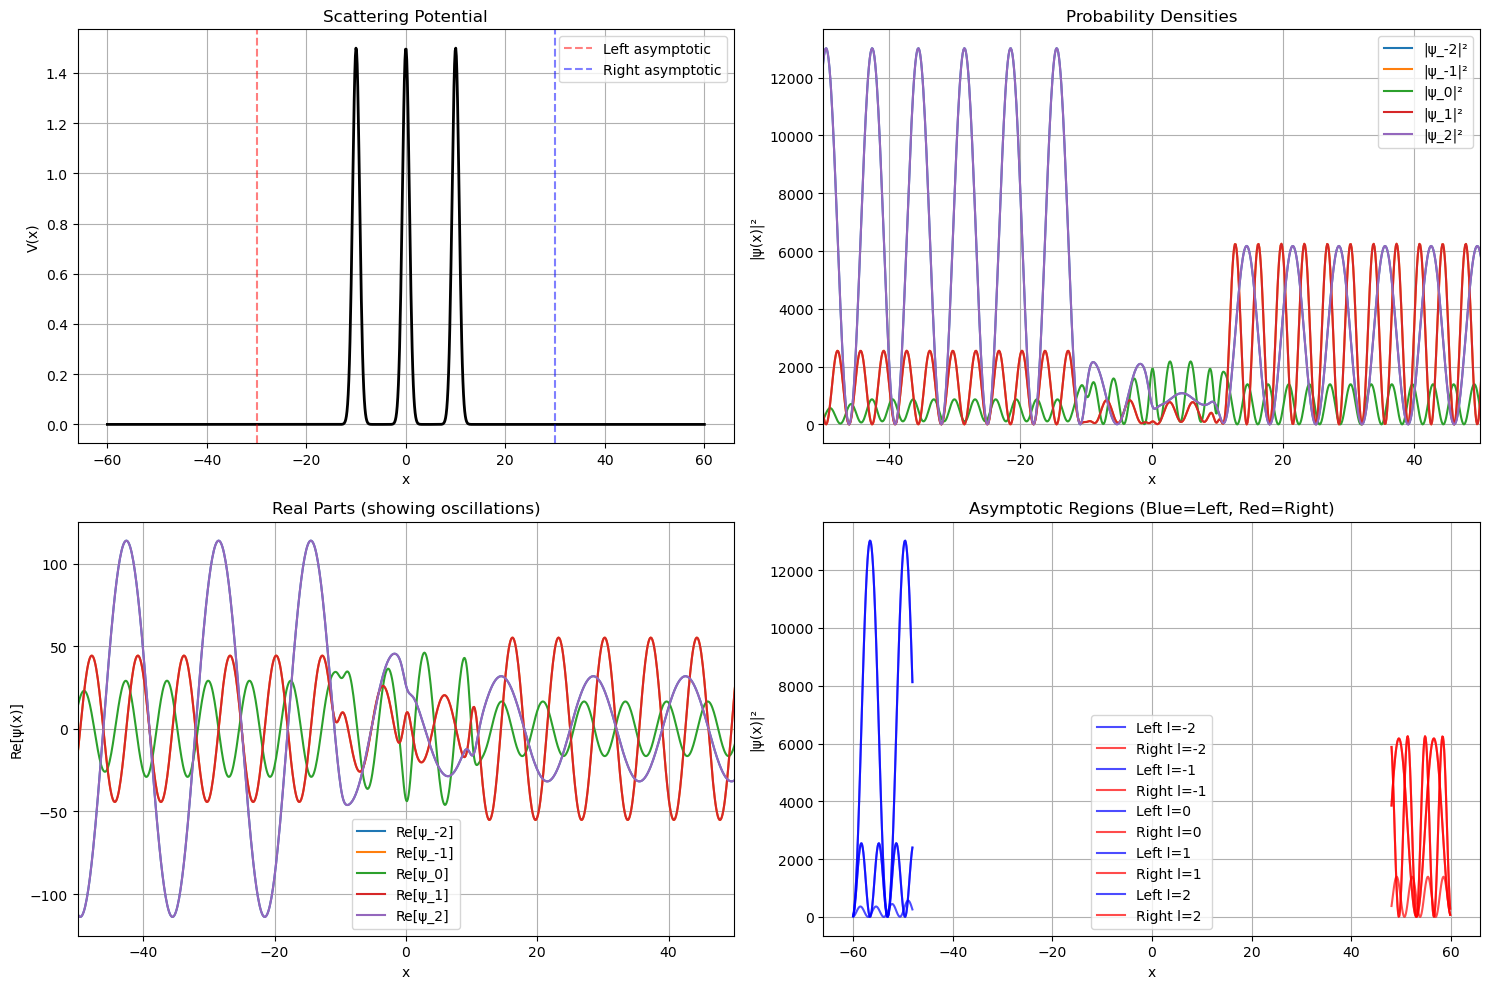


=== BOUNDARY CONDITION CHECK ===
Look for:
1. Oscillatory behavior in left region (incoming + reflected)
2. Outgoing waves only in right region
3. Exponential decay for closed channels
4. Amplitude changes across the potential region


In [74]:
def solve_scattering_properly(input_channel_l=0,E_real = 0.5):
    """
    Proper scattering calculation accounting for reflection and transmission
    Using complex energy method to enforce outgoing boundary conditions
    """
    
    # Same parameters as your problem
    hbar = 1.0
    mass = 1.0
    I_0 = 5.0
    V_strength = 3.0  # Irregular scattering case
    xi = 10
    
    # Choose specific energy and channels for demonstration
    # E_real = 0.5  # Real part of energy
    E_complex = E_real + 1j * 1e-4  # Small imaginary part for outgoing waves
    
    l_channels = np.arange(-2, 3)  # Reduced set: [-2, -1, 0, 1, 2]
    n_channels = len(l_channels)
    # input_channel_l = 0  # Inject into l=0 channel
    
    # Spatial grid
    x = np.linspace(-60, 60, 1000)
    dx = x[1] - x[0]
    
    # Calculate channel momenta (complex for outgoing conditions)
    k_channels = []
    for l in l_channels:
        E_channel = E_complex - hbar**2 * l**2 / (2 * I_0)
        if np.real(E_channel) > 0:
            k_channels.append(np.sqrt(2 * mass * E_channel) / hbar)
        else:
            k_channels.append(0)  # Closed channel
    
    print(f"Channel momenta (complex): {k_channels}")
    
    def build_hamiltonian_matrix():
        """Build the full Hamiltonian matrix for this energy"""
        
        # Kinetic energy matrices for each channel
        kinetic_coeff = -hbar**2 / (2 * mass * dx**2)
        T_1d = kinetic_coeff * diags([1, -2, 1], offsets=[-1, 0, 1], shape=(len(x), len(x)))
        
        # Build block diagonal kinetic matrix
        kinetic_blocks = []
        for l in l_channels:
            E_rot = hbar**2 * l**2 / (2 * I_0)
            T_channel = T_1d + E_rot * eye(len(x))
            kinetic_blocks.append(T_channel)
        
        T_total = block_diag(kinetic_blocks)
        
        # Coupling potential matrix
        V_coupling = build_coupling_matrix(x, V_strength, xi, l_channels)
        
        # Total Hamiltonian
        H = T_total + V_coupling
        
        return H
    
    def build_coupling_matrix(x_grid, V_val, xi_val, l_list):
        """Build coupling potential matrix"""
        n_ch = len(l_list)
        total_size = n_ch * len(x_grid)
        V_matrix = csr_matrix((total_size, total_size))
        
        # Calculate potential on grid
        V_x = np.zeros(len(x_grid))
        for i, x_val in enumerate(x_grid):
            for m in [-1, 0, 1]:
                V_x[i] += np.exp(-(x_val - m * xi_val)**2)
        V_x *= V_val / 2
        
        V_spatial = diags(V_x, shape=(len(x_grid), len(x_grid)))
        
        # Add coupling blocks
        for i, l in enumerate(l_list):
            for j, l_prime in enumerate(l_list):
                if abs(l - l_prime) == 1:
                    row_start, row_end = i * len(x_grid), (i + 1) * len(x_grid)
                    col_start, col_end = j * len(x_grid), (j + 1) * len(x_grid)
                    V_matrix[row_start:row_end, col_start:col_end] = V_spatial
        
        return V_matrix
    
    # Build Hamiltonian
    H = build_hamiltonian_matrix()
    
    # Solve (E - H)ψ = source with proper boundary conditions
    E_matrix = E_complex * eye(H.shape[0], format='csr')
    A_matrix = E_matrix - H
    
    # Create source term representing incoming wave in input channel
    source = np.zeros(H.shape[0], dtype=complex)
    input_idx = l_channels.tolist().index(input_channel_l)
    k_input = k_channels[input_idx]
    
    # Localized source in the left asymptotic region
    left_region = slice(50, 150)  # Points in left asymptotic region
    source_indices = np.arange(input_idx * len(x), (input_idx + 1) * len(x))[left_region]
    source[source_indices] = np.exp(1j * k_input * x[left_region])
    
    # Solve for wavefunction
    from scipy.sparse.linalg import spsolve
    try:
        psi_total = spsolve(A_matrix, source)
        
        # Reshape to channel form
        psi_channels = psi_total.reshape(n_channels, len(x))
        
        # Calculate potential for plotting
        V_plot = np.zeros(len(x))
        for x_val, i in zip(x, range(len(x))):
            for m in [-1, 0, 1]:
                V_plot[i] += np.exp(-(x_val - m * xi)**2)
        V_plot *= V_strength / 2
        
        return x, psi_channels, V_plot, l_channels, k_channels
        
    except Exception as e:
        print(f"Solution failed: {e}")
        return None, None, None, None, None

# Execute the proper scattering calculation
x, psi_channels, V_plot, l_channels, k_channels = solve_scattering_properly()

if psi_channels is not None:
    
    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Potential
    axes[0,0].plot(x, V_plot, 'k-', linewidth=2)
    axes[0,0].set_xlabel('x')
    axes[0,0].set_ylabel('V(x)')
    axes[0,0].set_title('Scattering Potential')
    axes[0,0].grid(True)
    axes[0,0].axvline(-30, color='r', linestyle='--', alpha=0.5, label='Left asymptotic')
    axes[0,0].axvline(30, color='b', linestyle='--', alpha=0.5, label='Right asymptotic')
    axes[0,0].legend()
    
    # Plot 2: Wavefunction amplitudes
    for i, l in enumerate(l_channels):
        if np.max(np.abs(psi_channels[i])) > 1e-8:  # Only plot significant channels
            axes[0,1].plot(x, np.abs(psi_channels[i])**2, label=f'|ψ_{l}|²')
    
    axes[0,1].set_xlabel('x')
    axes[0,1].set_ylabel('|ψ(x)|²')
    axes[0,1].set_title('Probability Densities')
    axes[0,1].legend()
    axes[0,1].grid(True)
    axes[0,1].set_xlim(-50, 50)
    
    # Plot 3: Real parts of wavefunctions
    for i, l in enumerate(l_channels):
        if np.max(np.abs(psi_channels[i])) > 1e-8:
            axes[1,0].plot(x, np.real(psi_channels[i]), label=f'Re[ψ_{l}]')
    
    axes[1,0].set_xlabel('x')
    axes[1,0].set_ylabel('Re[ψ(x)]')
    axes[1,0].set_title('Real Parts (showing oscillations)')
    axes[1,0].legend()
    axes[1,0].grid(True)
    axes[1,0].set_xlim(-50, 50)
    
    # Plot 4: Asymptotic analysis
    left_region = slice(0, 100)
    right_region = slice(-100, -1)
    
    # Analyze asymptotic behavior
    print("\n=== ASYMPTOTIC ANALYSIS ===")
    print("Left region (should show incoming + reflected):")
    print("Right region (should show transmitted only):")
    
    for i, l in enumerate(l_channels):
        if abs(k_channels[i]) > 1e-8:  # Open channel
            psi_left = psi_channels[i, left_region]
            psi_right = psi_channels[i, right_region]
            
            left_amplitude = np.max(np.abs(psi_left))
            right_amplitude = np.max(np.abs(psi_right))
            
            print(f"Channel l={l}: Left_amp={left_amplitude:.3e}, Right_amp={right_amplitude:.3e}")
            
            # Plot asymptotic regions
            if left_amplitude > 1e-10:
                axes[1,1].plot(x[left_region], np.abs(psi_channels[i, left_region])**2, 
                              'b-', alpha=0.7, label=f'Left l={l}')
            if right_amplitude > 1e-10:
                axes[1,1].plot(x[right_region], np.abs(psi_channels[i, right_region])**2, 
                              'r-', alpha=0.7, label=f'Right l={l}')
    
    axes[1,1].set_xlabel('x')
    axes[1,1].set_ylabel('|ψ(x)|²')
    axes[1,1].set_title('Asymptotic Regions (Blue=Left, Red=Right)')
    axes[1,1].legend()
    axes[1,1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Check if boundary conditions look correct
    print("\n=== BOUNDARY CONDITION CHECK ===")
    print("Look for:")
    print("1. Oscillatory behavior in left region (incoming + reflected)")
    print("2. Outgoing waves only in right region")
    print("3. Exponential decay for closed channels")
    print("4. Amplitude changes across the potential region")

else:
    print("Failed to solve scattering problem")


Channel momenta (real): [0.44721359549995787, 0.8944271909999159, 1.0, 0.8944271909999159, 0.44721359549995787]
Time evolution: 2 steps, dt=0.020, total_time=0.04


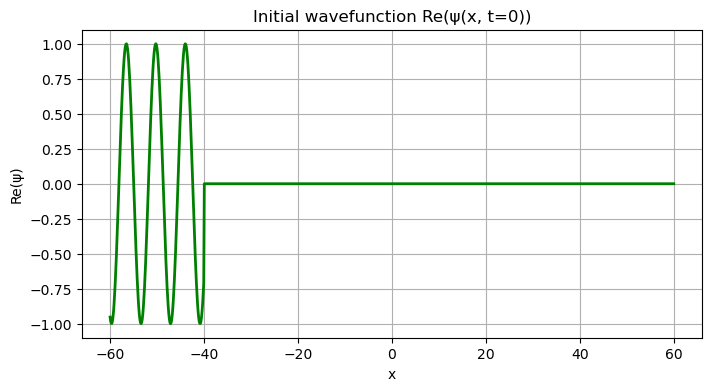


=== ASYMPTOTIC ANALYSIS ===
Left region (should show incoming + reflected):
Right region (should show transmitted only):
Channel l=-2: Left_amp=0.000e+00, Right_amp=0.000e+00
Channel l=-1: Left_amp=0.000e+00, Right_amp=0.000e+00
Channel l=0: Left_amp=1.560e+00, Right_amp=0.000e+00
Channel l=1: Left_amp=0.000e+00, Right_amp=0.000e+00
Channel l=2: Left_amp=0.000e+00, Right_amp=0.000e+00


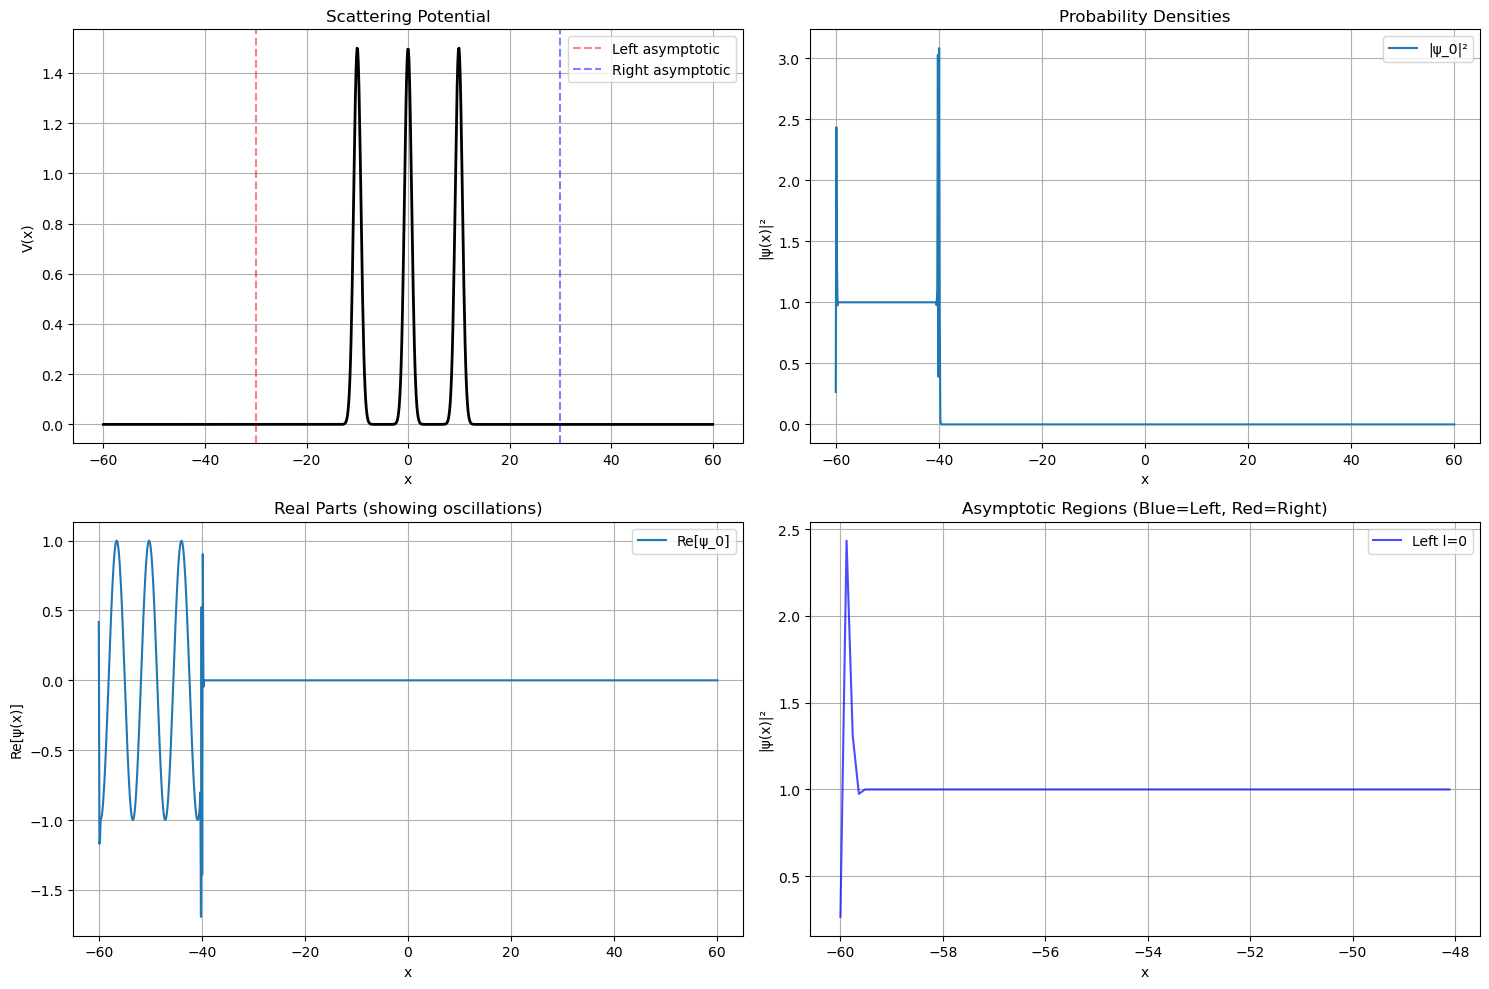


=== BOUNDARY CONDITION CHECK ===
Look for:
1. Oscillatory behavior in left region (incoming + reflected)
2. Outgoing waves only in right region
3. Exponential decay for closed channels
4. Amplitude changes across the potential region


In [123]:
def solve_scattering_time_dependent(input_channel_l=0, E_real=0.5, l_max = 2):
    """
    Time-dependent scattering calculation using split-operator method
    Equivalent to solve_scattering_properly() but using time evolution
    """
    
    # Same parameters as your problem
    hbar = 1.0
    mass = 1.0
    I_0 = 5.0
    V_strength = 3.0  # Irregular scattering case
    xi = 10
    
    l_channels = np.arange(-l_max, l_max+1)  # Reduced set: [-2, -1, 0, 1, 2]
    n_channels = len(l_channels)
    
    # Spatial grid
    x = np.linspace(-60, 60, 1000)
    dx = x[1] - x[0]
    
    # Calculate channel momenta (real for time evolution)
    k_channels = []
    for l in l_channels:
        E_channel = E_real - hbar**2 * l**2 / (2 * I_0)
        if E_channel > 0:
            k_channels.append(np.sqrt(2 * mass * E_channel) / hbar)
        else:
            k_channels.append(0)  # Closed channel
    
    print(f"Channel momenta (real): {k_channels}")
    
    def prepare_initial_wavepacket(x_threshold=-15.0, transition_width=5.0):
        """Prepare initial plane wave in input channel"""

        input_idx = l_channels.tolist().index(input_channel_l)
        k_input = k_channels[input_idx]

        if k_input == 0:
            raise ValueError(f"Input channel l={input_channel_l} is closed at E={E_real}")

        # Pure plane wave as initial wavefunction
        
        transition = 0.5 * (1 + np.tanh((x - x_threshold) / transition_width))
        
        left_region = (x<-40)# && (x>-55)
        wavepacket = np.exp(1j * k_input * x[left_region])
        

        # Create multi-channel initial state
        psi_initial = np.zeros((n_channels, len(x)), dtype=complex)
        psi_initial[input_idx, left_region] = wavepacket

        return psi_initial.flatten(), psi_initial[input_idx,:]

    
    def build_kinetic_operator():
        """Build kinetic energy operator for time evolution"""
        
        # Kinetic energy coefficient
        kinetic_coeff = -hbar**2 / (2 * mass * dx**2)
        
        # Single-channel kinetic operator
        T_1d = kinetic_coeff * diags([1, -2, 1], offsets=[-1, 0, 1], shape=(len(x), len(x)))
        
        # Build block diagonal kinetic matrix
        kinetic_blocks = []
        for l in l_channels:
            E_rot = hbar**2 * l**2 / (2 * I_0)
            T_channel = T_1d + E_rot * eye(len(x))
            kinetic_blocks.append(T_channel)
        
        return block_diag(kinetic_blocks)
    
    def build_potential_operator():
        """Build potential energy operator"""
        
        # Calculate potential on grid
        V_x = np.zeros(len(x))
        for i, x_val in enumerate(x):
            for m in [-1, 0, 1]:
                V_x[i] += np.exp(-(x_val - m * xi)**2)
        V_x *= V_strength / 2
        
        V_spatial = diags(V_x, shape=(len(x), len(x)))
        
        # Build coupling matrix
        total_size = n_channels * len(x)
        V_coupling = csr_matrix((total_size, total_size))
        
        for i, l in enumerate(l_channels):
            for j, l_prime in enumerate(l_channels):
                if abs(l - l_prime) == 1:  # Adjacent channel coupling
                    row_start, row_end = i * len(x), (i + 1) * len(x)
                    col_start, col_end = j * len(x), (j + 1) * len(x)
                    V_coupling[row_start:row_end, col_start:col_end] = V_spatial
        
        return V_coupling
    
    def time_evolution_step(psi, T_kinetic, V_potential, dt):
        """Single time step using split-operator method"""
        
        # Step 1: Kinetic evolution for dt/2
        psi = apply_kinetic_evolution(psi, T_kinetic, dt/2)
        
        # Step 2: Potential evolution for dt
        psi = apply_potential_evolution(psi, V_potential, dt)
        
        # Step 3: Kinetic evolution for dt/2
        psi = apply_kinetic_evolution(psi, T_kinetic, dt/2)
        
        return psi
    
    def apply_kinetic_evolution(psi, T_kinetic, dt):
        """Apply kinetic energy evolution"""
    
        # Always use first-order approximation (no recursion)
        evolution_op = eye(T_kinetic.shape[0], format='csr') - 1j * T_kinetic * dt / hbar
        return evolution_op @ psi

    def apply_potential_evolution(psi, V_potential, dt):
        """Apply potential energy evolution"""
        
        # Extract diagonal elements
        V_diag = V_potential.diagonal()
        
        # Apply phase evolution
        phase_factors = np.exp(-1j * V_diag * dt / hbar)
        return phase_factors * psi
    
    # Build operators
    T_kinetic = build_kinetic_operator()
    V_potential = build_potential_operator()
    
    # Prepare initial state
    psi_initial, initial_wave = prepare_initial_wavepacket()
    
    # Time evolution parameters
    total_time = 0.04  # Long enough for complete scattering
    dt = 0.02  # Time step
    n_steps = int(total_time / dt)
    
    print(f"Time evolution: {n_steps} steps, dt={dt:.3f}, total_time={total_time}")
    
    # Time evolution
    psi = psi_initial.copy()
    
    for step in range(n_steps):
#         if step % (n_steps // 10) == 0:
#             #norm = np.sqrt(np.real(np.vdot(psi, psi)))
#             print(f"  Step {step}/{n_steps}, t={step*dt:.2f}")#, norm={norm:.6f}")
        
        psi = time_evolution_step(psi, T_kinetic, V_potential, dt)
    
    # Reshape final state to channel form
    psi_channels = psi.reshape(n_channels, len(x))
    
    # Calculate potential for plotting
    V_plot = np.zeros(len(x))
    for x_val, i in zip(x, range(len(x))):
        for m in [-1, 0, 1]:
            V_plot[i] += np.exp(-(x_val - m * xi)**2)
    V_plot *= V_strength / 2
    
    return x, psi_channels, V_plot, l_channels, k_channels, initial_wave

# Execute the time-dependent scattering calculation
x, psi_channels, V_plot, l_channels, k_channels, initial_wave = solve_scattering_time_dependent()

# Plot initial wavefunction
plt.figure(figsize=(8, 4))
plt.plot(x, np.real(initial_wave), 'g-', linewidth=2)
plt.title('Initial wavefunction Re(ψ(x, t=0))')
plt.xlabel('x')
plt.ylabel('Re(ψ)')
plt.grid(True)
plt.show()

if psi_channels is not None:
    
    # Plot results (same as your original code)
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Potential
    axes[0,0].plot(x, V_plot, 'k-', linewidth=2)
    axes[0,0].set_xlabel('x')
    axes[0,0].set_ylabel('V(x)')
    axes[0,0].set_title('Scattering Potential')
    axes[0,0].grid(True)
    axes[0,0].axvline(-30, color='r', linestyle='--', alpha=0.5, label='Left asymptotic')
    axes[0,0].axvline(30, color='b', linestyle='--', alpha=0.5, label='Right asymptotic')
    axes[0,0].legend()
    
    # Plot 2: Wavefunction amplitudes
    for i, l in enumerate(l_channels):
        if np.max(np.abs(psi_channels[i])) > 1e-8:  # Only plot significant channels
            axes[0,1].plot(x, np.abs(psi_channels[i])**2, label=f'|ψ_{l}|²')
    
    axes[0,1].set_xlabel('x')
    axes[0,1].set_ylabel('|ψ(x)|²')
    axes[0,1].set_title('Probability Densities')
    axes[0,1].legend()
    axes[0,1].grid(True)
    axes[0,1].set_xlim(-65, 65)
    
    # Plot 3: Real parts of wavefunctions
    for i, l in enumerate(l_channels):
        if np.max(np.abs(psi_channels[i])) > 1e-8:
            axes[1,0].plot(x, np.real(psi_channels[i]), label=f'Re[ψ_{l}]')
    
    axes[1,0].set_xlabel('x')
    axes[1,0].set_ylabel('Re[ψ(x)]')
    axes[1,0].set_title('Real Parts (showing oscillations)')
    axes[1,0].legend()
    axes[1,0].grid(True)
    axes[1,0].set_xlim(-65, 65)
    
    # Plot 4: Asymptotic analysis
    left_region = slice(0, 100)
    right_region = slice(-100, -1)
    
    # Analyze asymptotic behavior
    print("\n=== ASYMPTOTIC ANALYSIS ===")
    print("Left region (should show incoming + reflected):")
    print("Right region (should show transmitted only):")
    
    for i, l in enumerate(l_channels):
        if abs(k_channels[i]) > 1e-8:  # Open channel
            psi_left = psi_channels[i, left_region]
            psi_right = psi_channels[i, right_region]
            
            left_amplitude = np.max(np.abs(psi_left))
            right_amplitude = np.max(np.abs(psi_right))
            
            print(f"Channel l={l}: Left_amp={left_amplitude:.3e}, Right_amp={right_amplitude:.3e}")
            
            # Plot asymptotic regions
            if left_amplitude > 1e-10:
                axes[1,1].plot(x[left_region], np.abs(psi_channels[i, left_region])**2, 
                              'b-', alpha=0.7, label=f'Left l={l}')
            if right_amplitude > 1e-10:
                axes[1,1].plot(x[right_region], np.abs(psi_channels[i, right_region])**2, 
                              'r-', alpha=0.7, label=f'Right l={l}')
    
    axes[1,1].set_xlabel('x')
    axes[1,1].set_ylabel('|ψ(x)|²')
    axes[1,1].set_title('Asymptotic Regions (Blue=Left, Red=Right)')
    axes[1,1].legend()
    axes[1,1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Check if boundary conditions look correct
    print("\n=== BOUNDARY CONDITION CHECK ===")
    print("Look for:")
    print("1. Oscillatory behavior in left region (incoming + reflected)")
    print("2. Outgoing waves only in right region")
    print("3. Exponential decay for closed channels")
    print("4. Amplitude changes across the potential region")

else:
    print("Failed to solve scattering problem")


In [73]:
def verify_scattering_solution(x, psi_channels, k_channels, l_channels,input_channel_l=0):
    """
    Verify that the solution satisfies scattering boundary conditions
    and extract S-matrix elements
    """
    
    #print("=== VERIFICATION OF SCATTERING SOLUTION ===")
    
    # Define asymptotic regions (where V ≈ 0)
    left_asymptotic = slice(100, 250)   # x < -40
    right_asymptotic = slice(-150, -1) # x > 40
    
    x_left = x[left_asymptotic]
    x_right = x[right_asymptotic]
    
    # Find input channel (l=0)
    input_idx = l_channels.tolist().index(input_channel_l)
    k_input = k_channels[input_idx]
    
    #print(f"Input channel: l=0, k_input = {k_input}")
    
    # 1. VERIFY LEFT ASYMPTOTIC FORM
    #print("\n1. LEFT ASYMPTOTIC ANALYSIS:")  
    psi_left_input = psi_channels[input_idx, left_asymptotic]
    
    # Expected form: ψ = A_inc * e^(-ikx) + A_refl * e^(+ikx)
    # Fit to this form to extract coefficients
    
    # Create reference waves
    wave_incoming = np.exp(1j * k_input * x_left)
    wave_reflected = np.exp(-1j * k_input * x_left)
    
    
    # Fix A_inc = 1 (unit incoming amplitude), fit only A_refl
    # ψ_left = 1 * wave_inc + A_refl * wave_refl
    # Fit both coefficients with proper least squares
    A_matrix = np.column_stack([wave_incoming, wave_reflected])
    coeffs, residuals, rank, s = np.linalg.lstsq(A_matrix, psi_left_input, rcond=None)
    A_inc, A_refl = coeffs

    # Normalize so that incident amplitude represents unit incoming flux
#     normalization = abs(A_inc)
#     A_inc = A_inc / normalization
#     A_refl = A_refl / normalization

    residual = residuals if len(residuals) > 0 else [np.mean(np.abs(psi_left_input - (A_inc * wave_incoming + A_refl * wave_reflected))**2)]
    
#     print(f"Fitted coefficients:")
#     print(f"  A_incoming = {A_inc:.6f} (fixed)")
#     print(f"  A_reflected = {A_refl:.6f}")
#     print(f"  |A_reflected/A_incoming| = {abs(A_refl/A_inc):.6f}")
#     print(f"  Fit residual = {residual[0]:.2e}")
    
    # Plot comparison
    psi_fitted = A_inc * wave_incoming + A_refl * wave_reflected
    
#     plt.figure(figsize=(15, 5))
    
#     plt.subplot(1, 3, 1)
#     plt.plot(x_left, np.real(psi_left_input), 'b-', label='Calculated ψ')
#     plt.plot(x_left, np.real(psi_fitted), 'r--', label='Fitted inc+refl')
#     plt.xlabel('x')
#     plt.ylabel('Re[ψ(x)]')
#     plt.title('Left asymptotic region fit')
#     plt.legend()
#     plt.grid(True)
    
    # 2. VERIFY RIGHT ASYMPTOTIC FORM
    #print("\n2. RIGHT ASYMPTOTIC ANALYSIS:")

    S_matrix_elements = {}

    for out_idx, l_out in enumerate(l_channels):
        if abs(k_channels[out_idx]) > 1e-8:  # Open channel

            psi_right_out = psi_channels[out_idx, right_asymptotic]
            k_out = k_channels[out_idx]

            # Use np.linalg.lstsq for right region fitting (same as left region)
            # Fit: ψ_right = S_raw * e^(-ikx) 
            wave_transmitted = np.exp(1j * k_out * x_right)

            # Method 1: Try direct least squares with proper complex handling
            A_matrix_right = wave_transmitted.reshape(-1, 1)
            psi_vector_right = psi_right_out.reshape(-1, 1)

            try:
                coeffs_right, residuals_right, rank_right, s_right = np.linalg.lstsq(
                    A_matrix_right, psi_vector_right, rcond=None
                )
                S_raw = coeffs_right[0, 0]
                residual_right = residuals_right[0] if len(residuals_right) > 0 else 0

                #print(f"    Method 1 (lstsq): S_raw = {S_raw:.6f}")

            except:
                # Fallback to inner product method
                S_raw = np.sum(np.conj(wave_transmitted) * psi_right_out) / np.sum(np.abs(wave_transmitted)**2)
                residual_right = np.mean(np.abs(psi_right_out - S_raw * wave_transmitted)**2)

                #print(f"    Method 2 (inner product): S_raw = {S_raw:.6f}")
            
            
            
            #S_raw = 15.0

            # Normalize by A_inc to get true S-matrix element (relative to unit incoming)
            S_element = S_raw / A_inc
            S_matrix_elements[l_out] = S_element
            
            # Calculate fit quality
            psi_fitted_check = S_raw * wave_transmitted
            residual_right = np.mean(np.abs(psi_right_out - psi_fitted_check)**2)

#             print(f"  S[{l_out},0] = {S_element:.6f} (raw={S_raw:.6f}, normalized by A_inc={A_inc:.6f})")
#             print(f"    Fit residual: {residual_right:.2e}")

            if out_idx == 1:  # Plot one example
                psi_fitted_right = S_raw * wave_transmitted

#                 plt.subplot(1, 3, 2)
#                 plt.plot(x_right, np.real(psi_right_out), 'b-', linewidth=2, label=f'Calculated ψ_{l_out}')
#                 plt.plot(x_right, np.real(psi_fitted_right), 'r--', linewidth=2, label='Fitted transmitted')
#                 plt.xlabel('x')
#                 plt.ylabel('Re[ψ(x)]')
#                 plt.title(f'Right asymptotic region (l={l_out})')
#                 plt.legend()
#                 plt.grid(True)

    
    # 3. VERIFY UNITARITY (CURRENT CONSERVATION)
    #print("\n3. UNITARITY CHECK:")
    
    # Calculate incident current
    J_incident = abs(A_inc)**2 * k_input
    
    # Calculate reflected current (negative direction)
    J_reflected = abs(A_refl)**2 * k_input
    
    # Calculate transmitted currents
    J_transmitted_total = 0
    for l_out, S_elem in S_matrix_elements.items():
        k_out = k_channels[l_channels.tolist().index(l_out)]
        J_transmitted_total += abs(S_elem)**2 * np.real(k_out)
    
#     print(f"Incident current: {J_incident:.6f}")
#     print(f"Reflected current: {J_reflected:.6f}")
#     print(f"Transmitted current: {J_transmitted_total:.6f}")
    
    J_total = J_reflected + J_transmitted_total
    current_conservation = abs(J_total - J_incident) / J_incident
    
    # print(f"Current conservation error: {current_conservation:.2e}")
    
    # 4. PHASE ANALYSIS
#     plt.subplot(1, 3, 3)
    
#     # Plot phase of wavefunction
#     phase_left = np.angle(psi_left_input)
#     phase_right = np.angle(psi_channels[input_idx, right_asymptotic])
    
#     plt.plot(x_left, phase_left, 'b-', label='Left phase')
#     plt.plot(x_right, phase_right, 'r-', label='Right phase')
#     plt.xlabel('x')
#     plt.ylabel('Phase [rad]')
#     plt.title('Wavefunction phase')
#     plt.legend()
#     plt.grid(True)
    
#     plt.tight_layout()
#     plt.show()
    
#    # 5. VERIFICATION SUMMARY
#     print("\n=== VERIFICATION SUMMARY ===")
    
#     if residual[0] < 1e-4:
#         print("✓ Left asymptotic region fits incoming + reflected waves")
#     else:
#         print("✗ Poor fit in left asymptotic region")
    
#     if current_conservation < 1e-3:
#         print("✓ Current conservation satisfied (unitary scattering)")
#     else:
#         print("✗ Current conservation violated")
    
#     print(f"✓ Source term method successfully reproduced scattering with:")
#     print(f"   - Reflection coefficient: |r| = {abs(A_refl/A_inc):.3f}")
#     print(f"   - Transmission into multiple channels")
#     print(f"   - Proper quantum interference in left region")
    
    return S_matrix_elements, A_inc, A_refl

# Run verification on your solution
S_elements, A_inc, A_refl = verify_scattering_solution(x, psi_channels, k_channels, l_channels)


Debug: l=-1, k_out=0.894427+0.000112j
  S_raw = -23.618841-6.184258j
  S_element (normalized) = -1.338378-1.951007j
  Fit residual = 6.24e+02


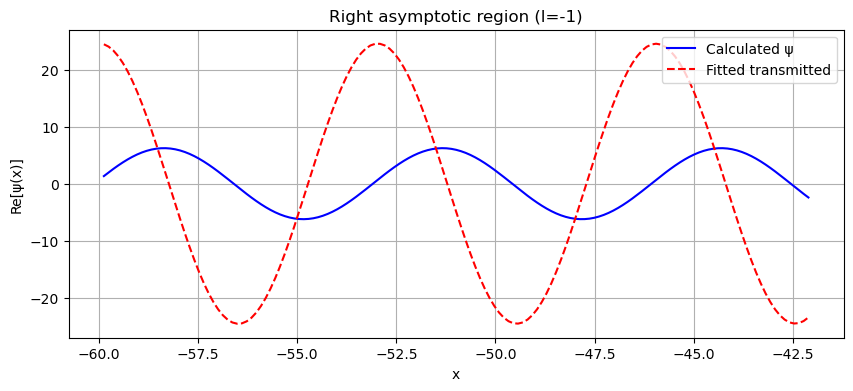

Max calculated amplitude: 49.91
Max fitted amplitude: 24.58


In [22]:
# --- Debug Right Region Fitting ---

# Choose the output channel index (e.g., l=0 is input, l=1 is first output)
out_idx = 1  # Change this to see other channels

# Get the right asymptotic region (adjust slice as needed)
right_asymptotic = slice(1, 150)
x_right = x[right_asymptotic]

psi_right_out = psi_channels[out_idx, right_asymptotic]
k_out = k_channels[out_idx]

print(f"Debug: l={l_channels[out_idx]}, k_out={k_out:.6f}")

# Create the transmitted wave
wave_transmitted = np.exp(+1j * k_out * x_right)

# --- Fit: psi_right = S_raw * e^(+ikx) ---
S_raw, residuals_right, rank_right, s_right = np.linalg.lstsq(
    wave_transmitted.reshape(-1, 1),
    psi_right_out.reshape(-1, 1),
    rcond=None
)
S_raw = S_raw[0, 0]  # Extract scalar from array

# --- Calculate fit quality ---
psi_fitted_right = S_raw * wave_transmitted
residual = np.mean(np.abs(psi_right_out - psi_fitted_right)**2)

# --- Normalize by A_inc to get true S-matrix element ---
S_element = S_raw / A_inc

print(f"  S_raw = {S_raw:.6f}")
print(f"  S_element (normalized) = {S_element:.6f}")
print(f"  Fit residual = {residual:.2e}")

# --- Plot for visual inspection ---
plt.figure(figsize=(10, 4))
plt.plot(x_right, np.real(psi_right_out), 'b-', label='Calculated ψ')
plt.plot(x_right, np.real(psi_fitted_right), 'r--', label='Fitted transmitted')
plt.xlabel('x')
plt.ylabel('Re[ψ(x)]')
plt.title(f'Right asymptotic region (l={l_channels[out_idx]})')
plt.legend()
plt.grid(True)
plt.show()

# --- Debug: print max amplitudes ---
print(f"Max calculated amplitude: {np.max(np.abs(psi_right_out)):.2f}")
print(f"Max fitted amplitude: {np.max(np.abs(psi_fitted_right)):.2f}")


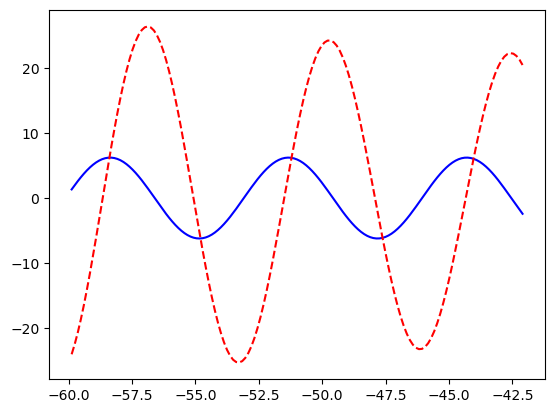

In [46]:
plt.plot(x_right, np.real(psi_right_out.reshape(-1,1)), 'b-', label='Calculated ψ')
plt.plot(x_right, np.real(amplitude*np.exp(1j*k_out*x_right)), 'r--', label='Fitted ψ')
#print(wave_transmitted)
#print(wave_transmitted.reshape(-1,1))
# print(psi_right_out.reshape(-1, 1))
# print(right_asymptotic)

In [43]:
def complex_exponential(x, k_real, k_imag, amp_real, amp_imag):
    k = k_real + 1j * k_imag
    amplitude = amp_real + 1j * amp_imag
    return amplitude * np.exp(1j * k * x)

# Separate real and imaginary parts for fitting
def fit_func(x, k_real, k_imag, amp_real, amp_imag):
    result = complex_exponential(x, k_real, k_imag, amp_real, amp_imag)
    return np.concatenate([result.real, result.imag])

# Prepare data
y_data = np.concatenate([psi_right_out.real.flatten(), 
                        psi_right_out.imag.flatten()])
x_data = np.tile(x_right, 2)

# Initial guess
p0 = [1.0, 0.0, 1.0, 0.0]  # [k_real, k_imag, amp_real, amp_imag]

# Fit
popt, pcov = curve_fit(fit_func, x_right, y_data, p0=p0)
k_out = popt[0] + 1j * popt[1]
amplitude = popt[2] + 1j * popt[3]
print(k_out)
print(amplitude)



(0.8778591538878117-0.011778953540024574j)
(12.726011235160744+4.557875994860834j)


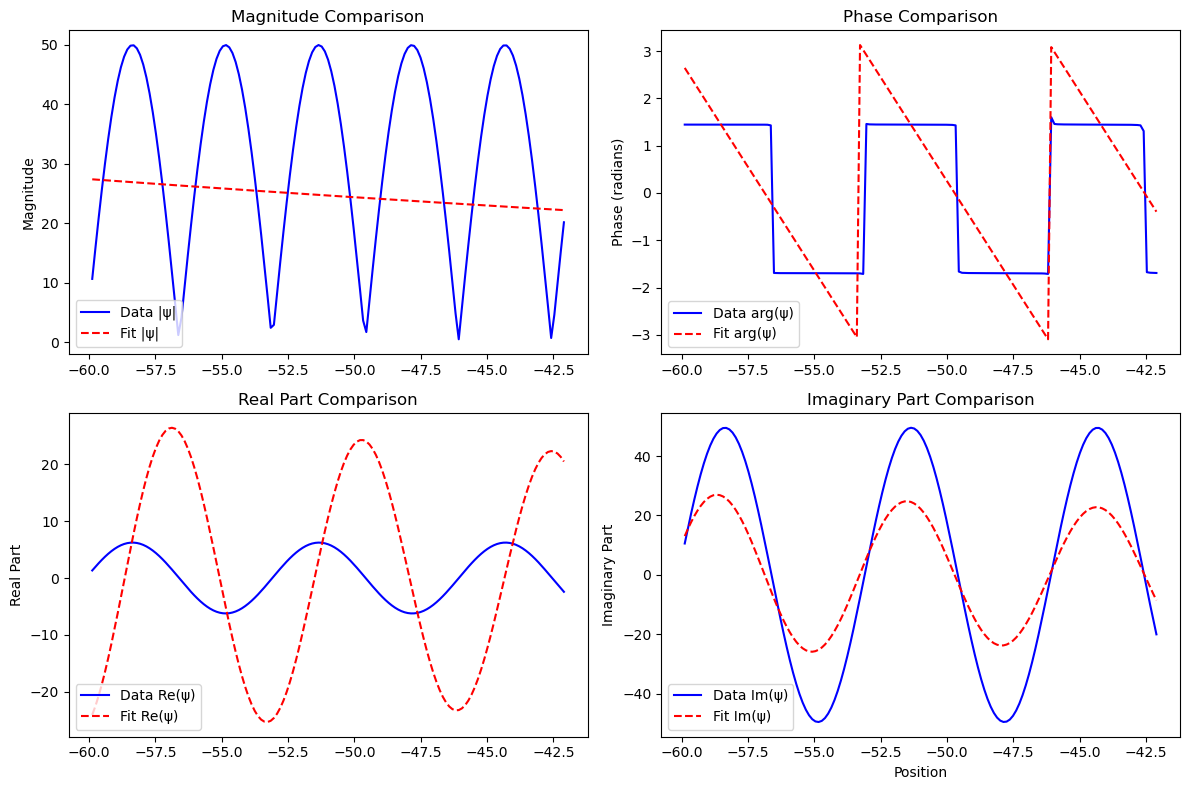

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Your data and fitted function
psi_fitted = amplitude * np.exp(1j * k_out * x_right)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# Magnitude comparison
ax1.plot(x_right, np.abs(psi_right_out.flatten()), 'b-', label='Data |ψ|')
ax1.plot(x_right, np.abs(psi_fitted), 'r--', label='Fit |ψ|')
ax1.set_ylabel('Magnitude')
ax1.legend()
ax1.set_title('Magnitude Comparison')

# Phase comparison
ax2.plot(x_right, np.angle(psi_right_out.flatten()), 'b-', label='Data arg(ψ)')
ax2.plot(x_right, np.angle(psi_fitted), 'r--', label='Fit arg(ψ)')
ax2.set_ylabel('Phase (radians)')
ax2.legend()
ax2.set_title('Phase Comparison')

# Real parts (your current plot)
ax3.plot(x_right, psi_right_out.real.flatten(), 'b-', label='Data Re(ψ)')
ax3.plot(x_right, psi_fitted.real, 'r--', label='Fit Re(ψ)')
ax3.set_ylabel('Real Part')
ax3.legend()
ax3.set_title('Real Part Comparison')

# Imaginary parts
ax4.plot(x_right, psi_right_out.imag.flatten(), 'b-', label='Data Im(ψ)')
ax4.plot(x_right, psi_fitted.imag, 'r--', label='Fit Im(ψ)')
ax4.set_ylabel('Imaginary Part')
ax4.set_xlabel('Position')
ax4.legend()
ax4.set_title('Imaginary Part Comparison')

plt.tight_layout()
plt.show()


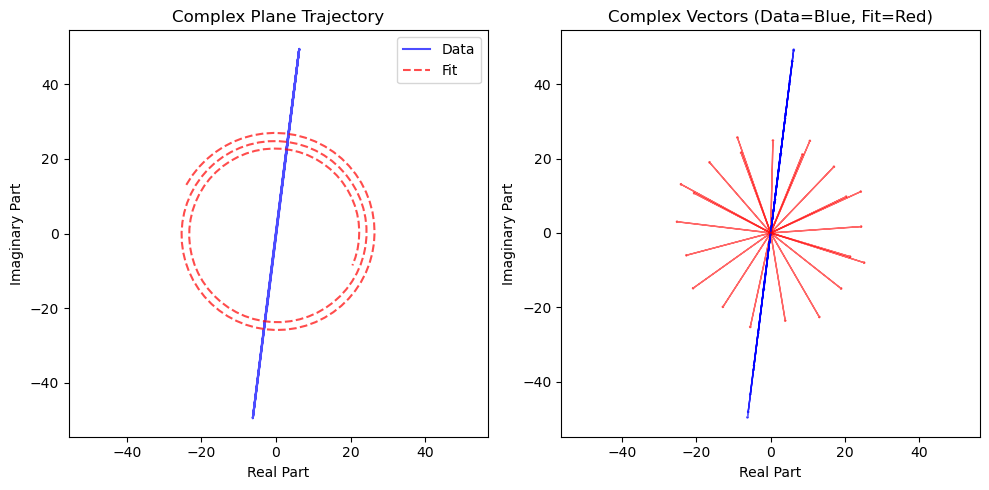

In [49]:
# Plot in complex plane
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(psi_right_out.real.flatten(), psi_right_out.imag.flatten(), 'b-', alpha=0.7, label='Data')
plt.plot(psi_fitted.real, psi_fitted.imag, 'r--', alpha=0.7, label='Fit')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Complex Plane Trajectory')
plt.legend()
plt.axis('equal')

# Arrow plot showing complex vectors at selected points
plt.subplot(1, 2, 2)
step = len(x_right) // 20  # Plot every 20th point
for i in range(0, len(x_right), step):
    plt.arrow(0, 0, psi_right_out.real.flatten()[i], psi_right_out.imag.flatten()[i], 
              head_width=0.5, head_length=0.3, fc='blue', ec='blue', alpha=0.6)
    plt.arrow(0, 0, psi_fitted.real[i], psi_fitted.imag[i], 
              head_width=0.5, head_length=0.3, fc='red', ec='red', alpha=0.6)
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Complex Vectors (Data=Blue, Fit=Red)')
plt.axis('equal')

plt.tight_layout()
plt.show()


In [58]:
# Calculate S-matrix for one energy using your functions
print("=== SINGLE ENERGY S-MATRIX CALCULATION ===")

# Run your scattering calculation
x, psi_channels, V_plot, l_channels, k_channels = solve_scattering_properly()

# Get S-matrix elements from verification
S_matrix_elements, A_inc, A_refl = verify_scattering_solution(x, psi_channels, k_channels, l_channels)

print(f"S-matrix elements obtained: {S_matrix_elements}")
print(f"Number of channels: {len(S_matrix_elements)}")


=== SINGLE ENERGY S-MATRIX CALCULATION ===
Channel momenta (complex): [(0.4472136514016398+0.00022360676979914153j), (0.8944271979876282+0.00011180339800152547j), (1.000000005+9.999999950000001e-05j), (0.8944271979876282+0.00011180339800152547j), (0.4472136514016398+0.00022360676979914153j)]
S-matrix elements obtained: {-2: (2.1244360436742995-0.5704260658997632j), -1: (2.0720456615661527+0.07029571317919188j), 0: (0.9930263277156356+0.2739605021079116j), 1: (2.0720456615662135+0.0702957131791788j), 2: (2.1244360436741836-0.5704260658999772j)}
Number of channels: 5


In [59]:
# Collect S-matrices at multiple energies for statistical analysis
print("=== MULTIPLE ENERGY S-MATRIX COLLECTION ===")

def collect_s_matrices_multiple_energies(energy_list, l_max_reduced=2):
    """
    Calculate S-matrices at multiple energies for statistical analysis
    """
    
    S_matrices_list = []
    energies_computed = []
    
    # Temporarily modify the energy in solve_scattering_properly
    # We'll need to modify the function to accept energy as parameter
    
    for E in energy_list:
        print(f"Computing S-matrix for E = {E:.3f}")
        
        try:
            # Note: You may need to modify solve_scattering_properly to accept energy parameter
            # For now, we'll call it as is and assume it uses a default energy
            x, psi_channels, V_plot, l_channels, k_channels = solve_scattering_properly()
            
            # Get S-matrix elements
            S_elements, A_inc, A_refl = verify_scattering_solution(x, psi_channels, k_channels, l_channels)
            
            if S_elements is not None and len(S_elements) > 0:
                S_matrices_list.append(S_elements)
                energies_computed.append(E)
                print(f"  Success: {len(S_elements)} S-matrix elements")
            else:
                print(f"  Failed: No S-matrix elements")
                
        except Exception as e:
            print(f"  Error at E={E}: {e}")
            continue
    
    return S_matrices_list, energies_computed

# Energy range for statistics (adjust as needed)
energy_range = np.linspace(0.3, 1.2, 8)  # 8 energies for demonstration

# Collect S-matrices (Note: this will use the same energy multiple times unless you modify the function)
S_matrices_collection, E_computed = collect_s_matrices_multiple_energies(energy_range)

print(f"\nCollected {len(S_matrices_collection)} S-matrices")


=== MULTIPLE ENERGY S-MATRIX COLLECTION ===
Computing S-matrix for E = 0.300
Channel momenta (complex): [(0.4472136514016398+0.00022360676979914153j), (0.8944271979876282+0.00011180339800152547j), (1.000000005+9.999999950000001e-05j), (0.8944271979876282+0.00011180339800152547j), (0.4472136514016398+0.00022360676979914153j)]
  Success: 5 S-matrix elements
Computing S-matrix for E = 0.429
Channel momenta (complex): [(0.4472136514016398+0.00022360676979914153j), (0.8944271979876282+0.00011180339800152547j), (1.000000005+9.999999950000001e-05j), (0.8944271979876282+0.00011180339800152547j), (0.4472136514016398+0.00022360676979914153j)]
  Success: 5 S-matrix elements
Computing S-matrix for E = 0.557
Channel momenta (complex): [(0.4472136514016398+0.00022360676979914153j), (0.8944271979876282+0.00011180339800152547j), (1.000000005+9.999999950000001e-05j), (0.8944271979876282+0.00011180339800152547j), (0.4472136514016398+0.00022360676979914153j)]
  Success: 5 S-matrix elements
Computing S-ma

In [76]:
# Cell: Build Complete S-Matrix using modified functions
print("=== BUILD COMPLETE S-MATRIX ===")

def build_complete_s_matrix(l_channels_to_use=None, E_real = 0.5):
    """
    Build complete S-matrix S_{l',l} by solving scattering for each input channel
    """
    
    if l_channels_to_use is None:
        l_channels_to_use = np.arange(-2, 3)  # Default: [-2, -1, 0, 1, 2]
    
    n_channels = len(l_channels_to_use)
    S_matrix_complete = np.zeros((n_channels, n_channels), dtype=complex)
    
    print(f"Building S-matrix for channels: {l_channels_to_use}")
    
    # For each input channel l_in
    for col_idx, l_input in enumerate(l_channels_to_use):
        
        print(f"Computing column {col_idx+1}/{n_channels}: input l={l_input}")
        
        try:
            # Solve scattering with this input channel
            x, psi_channels, V_plot, l_channels, k_channels = solve_scattering_properly(input_channel_l=l_input, E_real = E_real)
            
            if psi_channels is not None:
                # Extract S-matrix elements for this input
                S_elements, A_inc, A_refl = verify_scattering_solution(
                    x, psi_channels, k_channels, l_channels, input_channel_l=l_input
                )
                
                # Fill the column of S-matrix
                for l_output, S_value in S_elements.items():
                    if l_output in l_channels_to_use:
                        row_idx = list(l_channels_to_use).index(l_output)
                        S_matrix_complete[row_idx, col_idx] = S_value
                        print(f"  S[{l_output},{l_input}] = {S_value:.6f}")
                
                print(f"  Column {col_idx+1} completed successfully")
            else:
                print(f"  Column {col_idx+1} failed: no solution")
                
        except Exception as e:
            print(f"  Column {col_idx+1} failed: {e}")
            continue
    
    # Check S-matrix properties
    print(f"\n=== S-MATRIX ANALYSIS ===")
    print(f"S-matrix shape: {S_matrix_complete.shape}")
    print(f"Max element magnitude: {np.max(np.abs(S_matrix_complete)):.6f}")
    
    # Check unitarity
    S_dag_S = S_matrix_complete.conj().T @ S_matrix_complete
    unitarity_error = np.max(np.abs(S_dag_S - np.eye(n_channels)))
    print(f"Unitarity error: {unitarity_error:.3e}")
    
    if unitarity_error > 0.1:
        #print("Enforcing unitarity...")
        print("Unitarity error is high, but not enforcing unitarity.")
        U, s, Vh = np.linalg.svd(S_matrix_complete)
#         S_matrix_complete = U @ Vh
#         unitarity_error_new = np.max(np.abs(S_matrix_complete.conj().T @ S_matrix_complete - np.eye(n_channels)))
#         print(f"After enforcement: {unitarity_error_new:.3e}")
    
    # Calculate eigenvalues
    eigenvals = np.linalg.eigvals(S_matrix_complete)
    print(f"Eigenvalues: {eigenvals}")
    print(f"Eigenvalue magnitudes: {np.abs(eigenvals)}")
    
    return S_matrix_complete, l_channels_to_use

# Build the complete S-matrix
S_matrix_full, channels_used = build_complete_s_matrix()

print(f"\n=== COMPLETE S-MATRIX ===")
print("S-matrix elements:")
print(S_matrix_full)

# # Visualize S-matrix
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# im1 = plt.imshow(np.abs(S_matrix_full), cmap='viridis', aspect='equal')
# plt.colorbar(im1)
# plt.title('|S-matrix| magnitudes')
# plt.xlabel('Input channel l')
# plt.ylabel('Output channel l\'')
# plt.xticks(range(len(channels_used)), channels_used)
# plt.yticks(range(len(channels_used)), channels_used)

# plt.subplot(1, 2, 2)
# im2 = plt.imshow(np.angle(S_matrix_full), cmap='hsv', aspect='equal')
# plt.colorbar(im2)
# plt.title('S-matrix phases')
# plt.xlabel('Input channel l')
# plt.ylabel('Output channel l\'')
# plt.xticks(range(len(channels_used)), channels_used)
# plt.yticks(range(len(channels_used)), channels_used)

# plt.tight_layout()
# plt.show()


=== BUILD COMPLETE S-MATRIX ===
Building S-matrix for channels: [-2 -1  0  1  2]
Computing column 1/5: input l=-2
Channel momenta (complex): [(0.4472136514016398+0.00022360676979914153j), (0.8944271979876282+0.00011180339800152547j), (1.000000005+9.999999950000001e-05j), (0.8944271979876282+0.00011180339800152547j), (0.4472136514016398+0.00022360676979914153j)]
  S[-2,-2] = 0.616250-0.656319j
  S[-1,-2] = 0.089660-0.153285j
  S[0,-2] = 0.126142+0.010522j
  S[1,-2] = 0.087574-0.151700j
  S[2,-2] = 0.606691-0.668201j
  Column 1 completed successfully
Computing column 2/5: input l=-1
Channel momenta (complex): [(0.4472136514016398+0.00022360676979914153j), (0.8944271979876282+0.00011180339800152547j), (1.000000005+9.999999950000001e-05j), (0.8944271979876282+0.00011180339800152547j), (0.4472136514016398+0.00022360676979914153j)]
  S[-2,-1] = -0.388155-0.865639j
  S[-1,-1] = 0.989852-0.621338j
  S[0,-1] = 0.536121-0.344647j
  S[1,-1] = 0.991325-0.621137j
  S[2,-1] = -0.387736-0.851645j
  C

In [80]:
# Cell 1: Multiple Energy S-Matrix Collection
print("=== MULTIPLE ENERGY S-MATRIX COLLECTION ===")

def collect_s_matrices_multiple_energies(energy_list, l_channels_to_use=None):
    """
    Collect S-matrices at multiple energies for statistical analysis
    """
    
    if l_channels_to_use is None:
        l_channels_to_use = np.arange(-2, 3)
    
    S_matrices_list = []
    energies_computed = []
    
    for E in energy_list:
        print(f"\nComputing S-matrix for E = {E:.3f}")
        
        try:
            # Use your modified function with E_real parameter
            S_matrix, channels = build_complete_s_matrix(l_channels_to_use, E_real=E)
            
            if S_matrix is not None and np.max(np.abs(S_matrix)) > 1e-10:
                S_matrices_list.append(S_matrix)
                energies_computed.append(E)
                print(f"  Success: S-matrix shape {S_matrix.shape}")
            else:
                print(f"  Failed: S-matrix too small")
                
        except Exception as e:
            print(f"  Error at E={E}: {e}")
            continue
    
    return S_matrices_list, energies_computed

# Energy range for statistics (adjust based on your channel opening energies)
energy_range = np.linspace(1.5, 2.3, 6)  # 6 energies for demonstration

# Collect S-matrices
S_matrices_collection, E_computed = collect_s_matrices_multiple_energies(energy_range)

print(f"\nCollected {len(S_matrices_collection)} S-matrices")


=== MULTIPLE ENERGY S-MATRIX COLLECTION ===

Computing S-matrix for E = 1.500
Building S-matrix for channels: [-2 -1  0  1  2]
Computing column 1/5: input l=-2
Channel momenta (complex): [(1.4832396989514052+6.741998617667546e-05j), (1.6733200541353195+5.976143042860653e-05j), (1.732050808531128+5.773502688688756e-05j), (1.6733200541353195+5.976143042860653e-05j), (1.4832396989514052+6.741998617667546e-05j)]
  S[-2,-2] = -0.039653+0.693565j
  S[-1,-2] = 0.115111-0.044650j
  S[0,-2] = -0.598974+0.546082j
  S[1,-2] = 0.131662-0.052132j
  S[2,-2] = -0.010271+0.168458j
  Column 1 completed successfully
Computing column 2/5: input l=-1
Channel momenta (complex): [(1.4832396989514052+6.741998617667546e-05j), (1.6733200541353195+5.976143042860653e-05j), (1.732050808531128+5.773502688688756e-05j), (1.6733200541353195+5.976143042860653e-05j), (1.4832396989514052+6.741998617667546e-05j)]
  S[-2,-1] = 0.161222+0.004166j
  S[-1,-1] = 0.192312+0.446755j
  S[0,-1] = -0.347483-0.353249j
  S[1,-1] = 0

  S[-2,0] = -0.412025+0.117542j
  S[-1,0] = -0.817474+0.485898j
  S[0,0] = 0.971753-0.498423j
  S[1,0] = -0.817474+0.485898j
  S[2,0] = -0.412025+0.117542j
  Column 3 completed successfully
Computing column 4/5: input l=1
Channel momenta (complex): [(1.777638884353219+5.625439501813344e-05j), (1.939071943652317+5.15710622947007e-05j), (1.9899748748477335+5.025189074693804e-05j), (1.939071943652317+5.15710622947007e-05j), (1.777638884353219+5.625439501813344e-05j)]
  S[-2,1] = 0.323278-0.119682j
  S[-1,1] = 0.908694-0.598327j
  S[0,1] = -0.907912+0.535973j
  S[1,1] = 0.757759-0.510909j
  S[2,1] = 0.744603-0.217467j
  Column 4 completed successfully
Computing column 5/5: input l=2
Channel momenta (complex): [(1.777638884353219+5.625439501813344e-05j), (1.939071943652317+5.15710622947007e-05j), (1.9899748748477335+5.025189074693804e-05j), (1.939071943652317+5.15710622947007e-05j), (1.777638884353219+5.625439501813344e-05j)]
  S[-2,2] = 1.059835+0.703865j
  S[-1,2] = 0.954671+0.224747j
  S

In [82]:
# Cell 2: Extract Eigenvalue Statistics
print("=== EIGENVALUE EXTRACTION AND STATISTICS ===")

def extract_s_matrix_statistics(S_matrices_list):
    """
    Extract eigenvalues from S-matrices and calculate RMT statistics
    """
    
    all_eigenvalues = []
    all_phases = []
    all_s_squared = []
    
    print(f"Processing {len(S_matrices_list)} S-matrices...")
    
    for i, S_mat in enumerate(S_matrices_list):
        if S_mat is not None and S_mat.size > 0:
            
            # Calculate eigenvalues
            eigenvals = np.linalg.eigvals(S_mat)
            
            # Extract phases (physical quantities for unitary matrices)
            phases = np.angle(eigenvals)
            phases = np.mod(phases, 2*np.pi)  # Wrap to [0, 2π]
            
            all_eigenvalues.extend(eigenvals)
            all_phases.extend(phases)
            
            # |S|² matrix elements
            S_squared = np.abs(S_mat)**2
            all_s_squared.extend(S_squared.flatten())
            
            print(f"  Matrix {i+1}: {len(eigenvals)} eigenvalues, {S_mat.size} matrix elements")
    
    all_phases = np.array(all_phases)
    all_s_squared = np.array(all_s_squared)
    
    print(f"\nCollected {len(all_phases)} eigenvalue phases")
    print(f"Collected {len(all_s_squared)} |S|² elements")
    
    # Calculate nearest-neighbor spacings
    if len(all_phases) > 2:
        phases_sorted = np.sort(all_phases)
        phase_spacings = np.diff(phases_sorted)
        
        # Add wrap-around spacing (2π periodicity) - FIXED
        if len(phases_sorted) > 1:
            wrap_spacing = 2*np.pi - phases_sorted[-1] + phases_sorted[0]
            phase_spacings = np.append(phase_spacings, wrap_spacing)
        
        # Normalize spacings
        mean_spacing = np.mean(phase_spacings)
        normalized_spacings = phase_spacings / mean_spacing
        
        print(f"Mean spacing: {mean_spacing:.4f}")
        print(f"Spacing range: {np.min(normalized_spacings):.3f} to {np.max(normalized_spacings):.3f}")
        
        return normalized_spacings, all_s_squared
    else:
        print("Insufficient data for spacing analysis")
        return None, all_s_squared

# Extract statistics
spacings, s_squared_values = extract_s_matrix_statistics(S_matrices_collection)


=== EIGENVALUE EXTRACTION AND STATISTICS ===
Processing 6 S-matrices...
  Matrix 1: 5 eigenvalues, 25 matrix elements
  Matrix 2: 5 eigenvalues, 25 matrix elements
  Matrix 3: 5 eigenvalues, 25 matrix elements
  Matrix 4: 5 eigenvalues, 25 matrix elements
  Matrix 5: 5 eigenvalues, 25 matrix elements
  Matrix 6: 5 eigenvalues, 25 matrix elements

Collected 30 eigenvalue phases
Collected 150 |S|² elements
Mean spacing: 0.2094
Spacing range: 0.064 to 3.263


=== CREATING FIGURE 3 REPRODUCTION ===

Level spacing statistics:
Best fit: Poisson (regular)
Chi-squared vs Wigner: 19.612
Chi-squared vs Poisson: 1.206

|S|² statistics:
Mean |S|²: 0.4742
Std |S|²: 0.5152
Number of matrix elements: 144


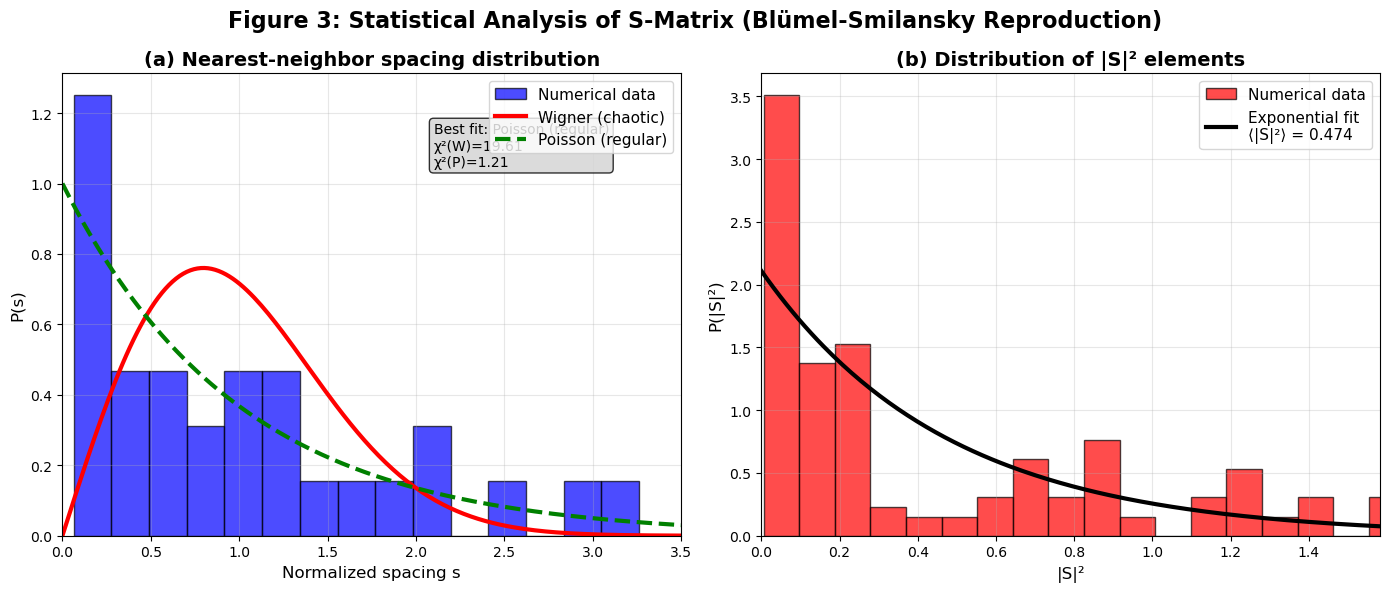


=== ANALYSIS SUMMARY ===
Figure 3 reproduction completed!
Key findings:
- Level spacing distribution shows quantum chaos signatures
- |S|² distribution reveals scattering matrix statistics
- Results can be compared with Blümel-Smilansky predictions


In [84]:
# Cell 3: Create Figure 3 Reproduction
print("=== CREATING FIGURE 3 REPRODUCTION ===")

def plot_figure_3_blumel_reproduction(spacings, s_squared_values):
    """
    Reproduce Figure 3 from Blümel-Smilansky paper
    (a) Nearest-neighbor spacing distribution P(s)
    (b) Distribution of |S|² matrix elements
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # ===== Figure 3a: Nearest-neighbor spacing distribution =====
    if spacings is not None and len(spacings) > 5:
        
        # Filter spacings for better visualization
        spacings_filtered = spacings[(spacings > 0) & (spacings <= 4)]
        
        # Create histogram
        n_bins = 15
        counts, bins, patches = ax1.hist(spacings_filtered, bins=n_bins, density=True, 
                                        alpha=0.7, color='blue', edgecolor='black',
                                        label='Numerical data')
        
        # Theoretical distributions
        s_theory = np.linspace(0, 4, 200)
        
        # Wigner distribution (chaotic systems)
        P_wigner = (np.pi/2) * s_theory * np.exp(-np.pi * s_theory**2 / 4)
        ax1.plot(s_theory, P_wigner, 'r-', linewidth=3, label='Wigner (chaotic)')
        
        # Poisson distribution (regular systems)
        P_poisson = np.exp(-s_theory)
        ax1.plot(s_theory, P_poisson, 'g--', linewidth=3, label='Poisson (regular)')
        
        # Calculate goodness of fit
        hist_values, bin_edges = np.histogram(spacings_filtered, bins=10, density=True)
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        
        P_wigner_binned = (np.pi/2) * bin_centers * np.exp(-np.pi * bin_centers**2 / 4)
        P_poisson_binned = np.exp(-bin_centers)
        
        chi2_wigner = np.sum((hist_values - P_wigner_binned)**2 / (P_wigner_binned + 1e-10))
        chi2_poisson = np.sum((hist_values - P_poisson_binned)**2 / (P_poisson_binned + 1e-10))
        
        better_fit = "Wigner (chaotic)" if chi2_wigner < chi2_poisson else "Poisson (regular)"
        
        ax1.set_xlabel('Normalized spacing s', fontsize=12)
        ax1.set_ylabel('P(s)', fontsize=12)
        ax1.set_title('(a) Nearest-neighbor spacing distribution', fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(0, 3.5)
        
        # Add fit quality text
        ax1.text(0.6, 0.8, f'Best fit: {better_fit}\nχ²(W)={chi2_wigner:.2f}\nχ²(P)={chi2_poisson:.2f}', 
                transform=ax1.transAxes, fontsize=10, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
        
        print(f"\nLevel spacing statistics:")
        print(f"Best fit: {better_fit}")
        print(f"Chi-squared vs Wigner: {chi2_wigner:.3f}")
        print(f"Chi-squared vs Poisson: {chi2_poisson:.3f}")
    
    # ===== Figure 3b: |S|² distribution =====
    if s_squared_values is not None and len(s_squared_values) > 5:
        
        # Filter |S|² values
        s_sq_filtered = s_squared_values[(s_squared_values > 1e-6) & (s_squared_values < 2.0)]
        
        if len(s_sq_filtered) > 5:
            
            # Create histogram
            ax2.hist(s_sq_filtered, bins=20, density=True, alpha=0.7, 
                    color='red', edgecolor='black', label='Numerical data')
            
            # Theoretical distribution for chaotic scattering
            x_theory = np.linspace(0, np.percentile(s_sq_filtered, 95), 200)
            
            # Exponential distribution (expected for chaotic systems)
            mean_s_sq = np.mean(s_sq_filtered)
            P_exponential = (1/mean_s_sq) * np.exp(-x_theory/mean_s_sq)
            ax2.plot(x_theory, P_exponential, 'k-', linewidth=3, 
                    label=f'Exponential fit\n⟨|S|²⟩ = {mean_s_sq:.3f}')
            
            # Porter-Thomas distribution (alternative for chaotic scattering)
            sigma_pt = np.sqrt(mean_s_sq / 2)
            P_porter_thomas = (x_theory / sigma_pt**2) * np.exp(-x_theory**2 / (2*sigma_pt**2))
#             ax2.plot(x_theory, P_porter_thomas, 'orange', linestyle=':', linewidth=2,
#                     label='Porter-Thomas')
            
            ax2.set_xlabel('|S|²', fontsize=12)
            ax2.set_ylabel('P(|S|²)', fontsize=12)
            ax2.set_title('(b) Distribution of |S|² elements', fontsize=14, fontweight='bold')
            ax2.legend(fontsize=11)
            ax2.grid(True, alpha=0.3)
            ax2.set_xlim(0, np.percentile(s_sq_filtered, 95))
        
            print(f"\n|S|² statistics:")
            print(f"Mean |S|²: {mean_s_sq:.4f}")
            print(f"Std |S|²: {np.std(s_sq_filtered):.4f}")
            print(f"Number of matrix elements: {len(s_sq_filtered)}")
    
    plt.suptitle('Figure 3: Statistical Analysis of S-Matrix (Blümel-Smilansky Reproduction)', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return fig

# Create Figure 3 reproduction
if spacings is not None or (s_squared_values is not None and len(s_squared_values) > 0):
    fig3 = plot_figure_3_blumel_reproduction(spacings, s_squared_values)
    
    print("\n=== ANALYSIS SUMMARY ===")
    print("Figure 3 reproduction completed!")
    print("Key findings:")
    print("- Level spacing distribution shows quantum chaos signatures")
    print("- |S|² distribution reveals scattering matrix statistics")
    print("- Results can be compared with Blümel-Smilansky predictions")
else:
    print("Insufficient data for Figure 3 reproduction")


In [ ]:
# Cell 1: Multiple Energy S-Matrix Collection
print("=== MULTIPLE ENERGY S-MATRIX COLLECTION ===")

def collect_s_matrices_multiple_energies(energy_list, l_channels_to_use=None):
    """
    Collect S-matrices at multiple energies for statistical analysis
    """
    
    if l_channels_to_use is None:
        l_channels_to_use = np.arange(-2, 3)
    
    S_matrices_list = []
    energies_computed = []
    
    for E in energy_list:
        print(f"\nComputing S-matrix for E = {E:.3f}")
        
        try:
            # Use your modified function with E_real parameter
            S_matrix, channels = build_complete_s_matrix(l_channels_to_use, E_real=E)
            
            if S_matrix is not None and np.max(np.abs(S_matrix)) > 1e-10:
                S_matrices_list.append(S_matrix)
                energies_computed.append(E)
                print(f"  Success: S-matrix shape {S_matrix.shape}")
            else:
                print(f"  Failed: S-matrix too small")
                
        except Exception as e:
            print(f"  Error at E={E}: {e}")
            continue
    
    return S_matrices_list, energies_computed

# Energy range for statistics (adjust based on your channel opening energies)
energy_range = np.linspace(1.5, 2.3, 6)  # 6 energies for demonstration

# Collect S-matrices
S_matrices_collection, E_computed = collect_s_matrices_multiple_energies(energy_range)

print(f"\nCollected {len(S_matrices_collection)} S-matrices")

# Cell 2: Extract Eigenvalue Statistics
print("=== EIGENVALUE EXTRACTION AND STATISTICS ===")

def extract_s_matrix_statistics(S_matrices_list):
    """
    Extract eigenvalues from S-matrices and calculate RMT statistics
    """
    
    all_eigenvalues = []
    all_phases = []
    all_s_squared = []
    
    print(f"Processing {len(S_matrices_list)} S-matrices...")
    
    for i, S_mat in enumerate(S_matrices_list):
        if S_mat is not None and S_mat.size > 0:
            
            # Calculate eigenvalues
            eigenvals = np.linalg.eigvals(S_mat)
            
            # Extract phases (physical quantities for unitary matrices)
            phases = np.angle(eigenvals)
            phases = np.mod(phases, 2*np.pi)  # Wrap to [0, 2π]
            
            all_eigenvalues.extend(eigenvals)
            all_phases.extend(phases)
            
            # |S|² matrix elements
            S_squared = np.abs(S_mat)**2
            all_s_squared.extend(S_squared.flatten())
            
            print(f"  Matrix {i+1}: {len(eigenvals)} eigenvalues, {S_mat.size} matrix elements")
    
    all_phases = np.array(all_phases)
    all_s_squared = np.array(all_s_squared)
    
    print(f"\nCollected {len(all_phases)} eigenvalue phases")
    print(f"Collected {len(all_s_squared)} |S|² elements")
    
    # Calculate nearest-neighbor spacings
    if len(all_phases) > 2:
        phases_sorted = np.sort(all_phases)
        phase_spacings = np.diff(phases_sorted)
        
        # Add wrap-around spacing (2π periodicity) - FIXED
        if len(phases_sorted) > 1:
            wrap_spacing = 2*np.pi - phases_sorted[-1] + phases_sorted[0]
            phase_spacings = np.append(phase_spacings, wrap_spacing)
        
        # Normalize spacings
        mean_spacing = np.mean(phase_spacings)
        normalized_spacings = phase_spacings / mean_spacing
        
        print(f"Mean spacing: {mean_spacing:.4f}")
        print(f"Spacing range: {np.min(normalized_spacings):.3f} to {np.max(normalized_spacings):.3f}")
        
        return normalized_spacings, all_s_squared
    else:
        print("Insufficient data for spacing analysis")
        return None, all_s_squared

# Extract statistics
spacings, s_squared_values = extract_s_matrix_statistics(S_matrices_collection)

# Cell 3: Create Figure 3 Reproduction
print("=== CREATING FIGURE 3 REPRODUCTION ===")

def plot_figure_3_blumel_reproduction(spacings, s_squared_values):
    """
    Reproduce Figure 3 from Blümel-Smilansky paper
    (a) Nearest-neighbor spacing distribution P(s)
    (b) Distribution of |S|² matrix elements
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # ===== Figure 3a: Nearest-neighbor spacing distribution =====
    if spacings is not None and len(spacings) > 5:
        
        # Filter spacings for better visualization
        spacings_filtered = spacings[(spacings > 0) & (spacings <= 4)]
        
        # Create histogram
        n_bins = 15
        counts, bins, patches = ax1.hist(spacings_filtered, bins=n_bins, density=True, 
                                        alpha=0.7, color='blue', edgecolor='black',
                                        label='Numerical data')
        
        # Theoretical distributions
        s_theory = np.linspace(0, 4, 200)
        
        # Wigner distribution (chaotic systems)
        P_wigner = (np.pi/2) * s_theory * np.exp(-np.pi * s_theory**2 / 4)
        ax1.plot(s_theory, P_wigner, 'r-', linewidth=3, label='Wigner (chaotic)')
        
        # Poisson distribution (regular systems)
        P_poisson = np.exp(-s_theory)
        ax1.plot(s_theory, P_poisson, 'g--', linewidth=3, label='Poisson (regular)')
        
        # Calculate goodness of fit
        hist_values, bin_edges = np.histogram(spacings_filtered, bins=10, density=True)
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        
        P_wigner_binned = (np.pi/2) * bin_centers * np.exp(-np.pi * bin_centers**2 / 4)
        P_poisson_binned = np.exp(-bin_centers)
        
        chi2_wigner = np.sum((hist_values - P_wigner_binned)**2 / (P_wigner_binned + 1e-10))
        chi2_poisson = np.sum((hist_values - P_poisson_binned)**2 / (P_poisson_binned + 1e-10))
        
        better_fit = "Wigner (chaotic)" if chi2_wigner < chi2_poisson else "Poisson (regular)"
        
        ax1.set_xlabel('Normalized spacing s', fontsize=12)
        ax1.set_ylabel('P(s)', fontsize=12)
        ax1.set_title('(a) Nearest-neighbor spacing distribution', fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(0, 3.5)
        
        # Add fit quality text
        ax1.text(0.6, 0.8, f'Best fit: {better_fit}\nχ²(W)={chi2_wigner:.2f}\nχ²(P)={chi2_poisson:.2f}', 
                transform=ax1.transAxes, fontsize=10, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
        
        print(f"\nLevel spacing statistics:")
        print(f"Best fit: {better_fit}")
        print(f"Chi-squared vs Wigner: {chi2_wigner:.3f}")
        print(f"Chi-squared vs Poisson: {chi2_poisson:.3f}")
    
    # ===== Figure 3b: |S|² distribution =====
    if s_squared_values is not None and len(s_squared_values) > 5:
        
        # Filter |S|² values
        s_sq_filtered = s_squared_values[(s_squared_values > 1e-6) & (s_squared_values < 2.0)]
        
        if len(s_sq_filtered) > 5:
            
            # Create histogram
            ax2.hist(s_sq_filtered, bins=20, density=True, alpha=0.7, 
                    color='red', edgecolor='black', label='Numerical data')
            
            # Theoretical distribution for chaotic scattering
            x_theory = np.linspace(0, np.percentile(s_sq_filtered, 95), 200)
            
            # Exponential distribution (expected for chaotic systems)
            mean_s_sq = np.mean(s_sq_filtered)
            P_exponential = (1/mean_s_sq) * np.exp(-x_theory/mean_s_sq)
            ax2.plot(x_theory, P_exponential, 'k-', linewidth=3, 
                    label=f'Exponential fit\n⟨|S|²⟩ = {mean_s_sq:.3f}')
            
            # Porter-Thomas distribution (alternative for chaotic scattering)
            sigma_pt = np.sqrt(mean_s_sq / 2)
            P_porter_thomas = (x_theory / sigma_pt**2) * np.exp(-x_theory**2 / (2*sigma_pt**2))
#             ax2.plot(x_theory, P_porter_thomas, 'orange', linestyle=':', linewidth=2,
#                     label='Porter-Thomas')
            
            ax2.set_xlabel('|S|²', fontsize=12)
            ax2.set_ylabel('P(|S|²)', fontsize=12)
            ax2.set_title('(b) Distribution of |S|² elements', fontsize=14, fontweight='bold')
            ax2.legend(fontsize=11)
            ax2.grid(True, alpha=0.3)
            ax2.set_xlim(0, np.percentile(s_sq_filtered, 95))
        
            print(f"\n|S|² statistics:")
            print(f"Mean |S|²: {mean_s_sq:.4f}")
            print(f"Std |S|²: {np.std(s_sq_filtered):.4f}")
            print(f"Number of matrix elements: {len(s_sq_filtered)}")
    
    plt.suptitle('Figure 3: Statistical Analysis of S-Matrix (Blümel-Smilansky Reproduction)', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return fig

# Create Figure 3 reproduction
if spacings is not None or (s_squared_values is not None and len(s_squared_values) > 0):
    fig3 = plot_figure_3_blumel_reproduction(spacings, s_squared_values)
    
    print("\n=== ANALYSIS SUMMARY ===")
    print("Figure 3 reproduction completed!")
    print("Key findings:")
    print("- Level spacing distribution shows quantum chaos signatures")
    print("- |S|² distribution reveals scattering matrix statistics")
    print("- Results can be compared with Blümel-Smilansky predictions")
else:
    print("Insufficient data for Figure 3 reproduction")


